# Оптимизация производственных расходод для металлургического комбината «Стальная птица»

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Наша задача — построить модель, которая будет её предсказывать. 

Заказчик хочет использовать разработанную модель для имитации технологического процесса.

**Цель исследования**

Уменьшение потребления электроэнергии на этапе обработки стали. 

---

**Задачи исследования**

Построить модель, которая будет предсказывать температуру сплава. 

---

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

**Исходные данные**  

Данные состоят из нескольких файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах:
    - key — номер партии;
    - Начало нагрева дугой — время начала нагрева;
    - Конец нагрева дугой — время окончания нагрева;
    - Активная мощность — значение активной мощности;
    - Реактивная мощность — значение реактивной мощности.
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
    - key — номер партии;
    - Bulk 1 … Bulk 15 — объём подаваемого материала.
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
    - key — номер партии;
    - Bulk 1 … Bulk 15 — время подачи материала.
- `data_gas_new.csv` — данные о продувке сплава газом;
    - key — номер партии;
    - Газ 1 — объём подаваемого газа.
- `data_temp_new.csv` — результаты измерения температуры;
    - key — номер партии;
    - Время замера — время замера;
    - Температура — значение температуры.
- `data_wire_new.csv` — данные о проволочных материалах (объём);
    - key — номер партии;
    - Wire 1 … Wire 9 — объём подаваемых проволочных материалов.
- `data_wire_time_new.csv` — данные о проволочных материалах (время).
    - key — номер партии;
    - Wire 1 … Wire 9 — время подачи проволочных материалов.
    
Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

----

**План работы**

***1. Загрузка данных***

Загрузка данных и их первичный осмотр.

***2. Исследовательский анализ и предобработка данных***

Исследовательский анализ каждого датафрейма и при необходимости предобработка данных. Выводы об имеющихся признаках: понадобятся ли они для обучения моделей.

***3. Объединение данных***

Объединим выбранные признаки в один датафрейм по ключу.

***4. Исследовательский анализ и предобработка данных объединённого датафрейма***

Исследовательский анализ объединённого датафрейма, визуализация распределения признаков и при необходимости  предобработка данных. Корреляционный анализ. 

***5. Подготовка данных***

Подготовка данных для обучения модели. Разделение данных на две выборки, при масштабировании и кодировании учтем особенности данных и моделей.

***6. Обучение моделей машинного обучения***

Обучим как минимум две модели. Хотя бы для одной из них подберем как минимум два гиперпараметра.

***7. Выбор лучшей модели***

Выберем лучшую модель и проверим её качество на тестовой выборке.

***8. Общий вывод и рекомендации заказчику***

Общий вывод о проделанной работе: описание основных этапов работы, полученных результатов и рекомендации для бизнеса.

## Подготовка данных

In [1]:
!pip install phik -q
!pip install lightgbm -q
!pip install catboost -q

In [2]:
#Подключение библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
import warnings
import phik
import lightgbm as lgb

plt.rcParams["figure.figsize"] = (15, 10)

from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import (
    Pipeline,
    make_pipeline)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

from sklearn.metrics import (mean_absolute_error)

In [3]:
# системные настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

In [4]:
#Объявим константы

RANDOM_STATE = 160924

### Загрузка данных и первичный осмотр


In [5]:
# В целях оптимизации, напишем функцию для получения общей информации о датасете
def describe_df(df, name):
    print('Размер датафрейма', name, ':', df.shape)
    print('_'*125)
    
    print('Первые 5 строк датафрейма', name)
    display(df.head())
    print('_'*125)
    
    print('Последнии 5 строк датафрейма', name)
    display(df.tail())
    print('_'*125)
    
    print('Информация о датафрейме', name)
    df.info()
    print('_'*125)
        
    print('Описание датафрейма', name)
    display(df.describe().T)
    print('_'*125)
    
    print('Количество явных дубликатов в датафрейте', name, ':', df.duplicated().sum())
    print('Количество пропусков в датафрейте', name, ':', '\n', df.isna().sum())
    
    print('*'*125)

#### Данные об электродах

In [6]:
#считывание данных из файла
pth1 = '/datasets/data_arc_new.csv'

if os.path.exists(pth1):
    data_arc_new = pd.read_csv(pth1)
else:
    print('Something is wrong')

In [7]:
#Вызовем функцию для датасета data_arc_new
describe_df(data_arc_new, 'data_arc_new')

Размер датафрейма data_arc_new : (14876, 5)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма data_arc_new


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма data_arc_new


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


_____________________________________________________________________________________________________________________________
Информация о датафрейме data_arc_new
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
_____________________________________________________________________________________________________________________________
Описание датафрейма data_arc_new


,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.662752,0.258885,0.223120,0.467115,0.599587,0.830070,1.463773
Реактивная мощность,14876.0,0.438986,5.873485,-715.479924,0.337175,0.441639,0.608201,1.270284


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте data_arc_new : 0
Количество пропусков в датафрейте data_arc_new : 
 key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64
*****************************************************************************************************************************


In [8]:
# Приведем название столбцов в единому стилю написания snake_case

data_arc_new = data_arc_new.rename(columns={'Начало нагрева дугой':'arc_heating_start', 
                        'Конец нагрева дугой':'arc_heating_finish', 
                        'Активная мощность':'active_power', 
                        'Реактивная мощность':'reactive_power'})

data_arc_new.head(1)

,key,arc_heating_start,arc_heating_finish,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.30513,0.211253


In [9]:
# В столбцах arc_heating_start и arc_heating_finish исправим тип данных

data_arc_new['arc_heating_start'] = pd.to_datetime(data_arc_new['arc_heating_start'], format='%Y-%m-%d %H:%M:%S')
data_arc_new['arc_heating_finish'] = pd.to_datetime(data_arc_new['arc_heating_finish'], format='%Y-%m-%d %H:%M:%S')

data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 14876 non-null  int64         
 1   arc_heating_start   14876 non-null  datetime64[ns]
 2   arc_heating_finish  14876 non-null  datetime64[ns]
 3   active_power        14876 non-null  float64       
 4   reactive_power      14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


**Вывод**

Данные в датасете об электродах соответствуют описанию.

Количество строк - 14 876, Количество столбцов - 5.

На этапе первичного осмотра данных:
    
- привели название столбцов в единому стилю написания snake_case
- исправили тип данных в столбцах arc_heating_start и arc_heating_finish на datetime
- убедились, что в данных нет дубликатов и пропусков

#### Данные о подаче сыпучих материалов (объём)

In [10]:
#считывание данных из файла
pth2 = '/datasets/data_bulk_new.csv'

if os.path.exists(pth2):
    data_bulk_new = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [11]:
#Вызовем функцию для датасета data_bulk_new
describe_df(data_bulk_new, 'data_bulk_new')

Размер датафрейма data_bulk_new : (3129, 16)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма data_bulk_new


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма data_bulk_new


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


_____________________________________________________________________________________________________________________________
Информация о датафрейме data_bulk_new
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 3

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте data_bulk_new : 0
Количество пропусков в датафрейте data_bulk_new : 
 key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
*****************************************************************************************************************************


In [12]:
# Приведем название столбцов в единому стилю написания snake_case
data_bulk_new.columns = [re.sub(r'\s+', '_', i).lower() for i in data_bulk_new.columns]
data_bulk_new.head(1)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0


Видим, что в данных есть пропуски. Это объясняется тем, что для текущей партии данный тип примесей вообще не применялся.  

**Вывод**

Данные о подаче сыпучих материалов (объём) соответствуют описанию.

Количество строк - 3 129, Количество столбцов - 16.

На этапе первичного осмотра данных:
    
- привели название столбцов в единому стилю написания snake_case
- проверили, что тип данных указан верно
- убедились, что в данных нет дубликатов 
- в данных обнаружены пропуски обработаем их на исследовательском этапе работы с данными

#### Данные о подаче сыпучих материалов (время)

In [13]:
#считывание данных из файла
pth3 = '/datasets/data_bulk_time_new.csv'

if os.path.exists(pth3):
    data_bulk_time_new = pd.read_csv(pth3)
else:
    print('Something is wrong')

In [14]:
#Вызовем функцию для датасета data_bulk_time_new
describe_df(data_bulk_time_new, 'data_bulk_time_new')

Размер датафрейма data_bulk_time_new : (3129, 16)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма data_bulk_time_new


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма data_bulk_time_new


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 17:26:33,2019-09-06 17:23:15


_____________________________________________________________________________________________________________________________
Информация о датафрейме data_bulk_time_new
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
_____

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте data_bulk_time_new : 0
Количество пропусков в датафрейте data_bulk_time_new : 
 key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
*****************************************************************************************************************************


In [15]:
# Приведем название столбцов в единому стилю написания snake_case
data_bulk_time_new.columns = [re.sub(r'\s+', '_', i).lower() for i in data_bulk_time_new.columns]
data_bulk_time_new.head(1)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43


Видим, что в данных есть пропуски. Это объясняется тем, что для текущей партии данный тип примесей вообще не применялся.

In [16]:
# Исправим тип данных в столбцах bulk

columns_bulk = data_bulk_time_new.columns
columns_bulk = columns_bulk[1:]

for i in columns_bulk:
    data_bulk_time_new[i] = pd.to_datetime(data_bulk_time_new[i], format='%Y-%m-%d %H:%M:%S')
    
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


**Вывод**

Данные о подаче сыпучих материалов (время) соответствуют описанию.

Количество строк - 3 129, Количество столбцов - 16.

На этапе первичного осмотра данных:
    
- привели название столбцов в единому стилю написания snake_case
- исправили тип данных в столбцах bulk на datetime
- убедились, что в данных нет дубликатов 
- в данных обнаружены пропуски обработаем их на исследовательском этапе работы с данными

#### Данные о продувке сплава газом

In [17]:
#считывание данных из файла
pth4 = '/datasets/data_gas_new.csv'

if os.path.exists(pth4):
    data_gas_new = pd.read_csv(pth4)
else:
    print('Something is wrong')

In [18]:
#Вызовем функцию для датасета data_gas_new
describe_df(data_gas_new, 'data_gas_new')

Размер датафрейма data_gas_new : (3239, 2)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма data_gas_new


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма data_gas_new


,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


_____________________________________________________________________________________________________________________________
Информация о датафрейме data_gas_new
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
_____________________________________________________________________________________________________________________________
Описание датафрейма data_gas_new


,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте data_gas_new : 0
Количество пропусков в датафрейте data_gas_new : 
 key      0
Газ 1    0
dtype: int64
*****************************************************************************************************************************


In [19]:
# Приведем название столбцов в единому стилю написания snake_case

data_gas_new = data_gas_new.rename(columns={'Газ 1':'gas_1'})

data_gas_new.head(1)

,key,gas_1
0,1,29.749986


**Вывод**

Данные в датасете о продувке сплава газом соответствуют описанию.

Количество строк - 3 239, Количество столбцов - 2.

На этапе первичного осмотра данных:
    
- привели название столбцов в единому стилю написания snake_case
- проверили, что тип данных указан верно
- убедились, что в данных нет дубликатов и пропусков

#### Результаты измерения температуры

In [20]:
#считывание данных из файла
pth5 = '/datasets/data_temp_new.csv'

if os.path.exists(pth5):
    data_temp_new = pd.read_csv(pth5)
else:
    print('Something is wrong')

In [21]:
#Вызовем функцию для датасета data_temp_new
describe_df(data_temp_new, 'data_temp_new')

Размер датафрейма data_temp_new : (18092, 3)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма data_temp_new


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма data_temp_new


,key,Время замера,Температура
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN


_____________________________________________________________________________________________________________________________
Информация о датафрейме data_temp_new
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
_____________________________________________________________________________________________________________________________
Описание датафрейма data_temp_new


,count,mean,std,min,25%,50%,75%,max
key,18092.0,1616.460977,934.641385,1.0,807.75,1618.0,2429.0,3241.0
Температура,14665.0,1590.722741,20.394381,1191.0,1580.00,1590.0,1599.0,1705.0


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте data_temp_new : 0
Количество пропусков в датафрейте data_temp_new : 
 key                0
Время замера       0
Температура     3427
dtype: int64
*****************************************************************************************************************************


In [22]:
# Приведем название столбцов в единому стилю написания snake_case

data_temp_new = data_temp_new.rename(columns={'Время замера':'time_measure', 
                        'Температура':'temperature'})

data_temp_new.head(1)

,key,time_measure,temperature
0,1,2019-05-03 11:02:04,1571.0


In [23]:
# Исправим тип данных в столбце time

data_temp_new['time_measure'] = pd.to_datetime(data_temp_new['time_measure'], format='%Y-%m-%d %H:%M:%S')

data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   time_measure  18092 non-null  datetime64[ns]
 2   temperature   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


**Вывод**

Данные в датасете с результатами измерения температуры соответствуют описанию.

Количество строк - 18 092, Количество столбцов - 3.

На этапе первичного осмотра данных:
    
- привели название столбцов в единому стилю написания snake_case
- исправили тип данных в столбце time_measure на datetime
- убедились, что в данных нет дубликатов
- в данных обнаружены пропуски обработаем их на исследовательском этапе работы с данными

#### Данные о проволочных материалах (объём)

In [24]:
#считывание данных из файла
pth6 = '/datasets/data_wire_new.csv'

if os.path.exists(pth6):
    data_wire_new = pd.read_csv(pth6)
else:
    print('Something is wrong')

In [25]:
#Вызовем функцию для датасета data_wire_new
describe_df(data_wire_new, 'data_wire_new')

Размер датафрейма data_wire_new : (3081, 10)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма data_wire_new


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма data_wire_new


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


_____________________________________________________________________________________________________________________________
Информация о датафрейме data_wire_new
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
_____________________________________________________________________________________________________________________________
Описание датафрейма data_wire_new


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте data_wire_new : 0
Количество пропусков в датафрейте data_wire_new : 
 key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
*****************************************************************************************************************************


In [26]:
# Приведем название столбцов в единому стилю написания snake_case
data_wire_new.columns = [re.sub(r'\s+', '_', i).lower() for i in data_wire_new.columns]
data_wire_new.head(1)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видим, что в данных есть пропуски. Это объясняется тем, что для текущей партии данный тип проволочных материалах вообще не применялся.

**Вывод**

Данные о проволочных материалах (объём) соответствуют описанию.

Количество строк - 3 081, Количество столбцов - 10.

На этапе первичного осмотра данных:
    
- привели название столбцов в единому стилю написания snake_case
- проверили, что тип данных указан верно
- убедились, что в данных нет дубликатов 
- в данных обнаружены пропуски обработаем их на исследовательском этапе работы с данными

#### Данные о проволочных материалах (время)

In [27]:
#считывание данных из файла
pth7 = '/datasets/data_wire_time_new.csv'

if os.path.exists(pth7):
    data_wire_time_new = pd.read_csv(pth7)
else:
    print('Something is wrong')

In [28]:
#Вызовем функцию для датасета data_wire_time_new
describe_df(data_wire_time_new, 'data_wire_time_new')

Размер датафрейма data_wire_time_new : (3081, 10)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма data_wire_time_new


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма data_wire_time_new


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-06 17:10:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


_____________________________________________________________________________________________________________________________
Информация о датафрейме data_wire_time_new
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
_____________________________________________________________________________________________________________________________
Описание датафрейма data_wire_time_new


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте data_wire_time_new : 0
Количество пропусков в датафрейте data_wire_time_new : 
 key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
*****************************************************************************************************************************


In [29]:
# Приведем название столбцов в единому стилю написания snake_case
data_wire_time_new.columns = [re.sub(r'\s+', '_', i).lower() for i in data_wire_time_new.columns]
data_wire_time_new.head(1)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Исправим тип данных в столбцах wire

columns_wire = data_wire_time_new.columns
columns_wire = columns_wire[1:]

for i in columns_wire:
    data_wire_time_new[i] = pd.to_datetime(data_wire_time_new[i], format='%Y-%m-%d %H:%M:%S')
    
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Видим, что в данных есть пропуски. Это объясняется тем, что для текущей партии данный тип проволочных материалах вообще не применялся.

**Вывод**

Данные о подаче сыпучих материалов (время) соответствуют описанию.

Количество строк - 3 081, Количество столбцов - 10.

На этапе первичного осмотра данных:
    
- привели название столбцов в единому стилю написания snake_case
- исправили тип данных в столбцах wire на datetime
- убедились, что в данных нет дубликатов 
- в данных обнаружены пропуски обработаем их на исследовательском этапе работы с данными

#### Промежуточный вывод о загрузке данных

Данные во всех датасетах соответствуют описанию.

На этапе первичного осмотра данных:
    
- привели название столбцов в единому стилю написания snake_case
- исправили тип данных в столбцах с датой на datetime
- убедились, что в данных нет явных дубликатов 
- в данных обнаружены пропуски обработаем их на исследовательском этапе работы с данными

### Исследовательский анализ и предобработка данных

In [31]:
# Напишем функцию построения гистограммы и диграммы размаха для количественных данных
def hix_box_plot(df, column):
    fig, ax = plt.subplots(nrows=2, ncols=1)
    fig.suptitle(f'Обзор данных {column}', fontsize = 20, fontweight='bold')
    fig.tight_layout(pad=5.0)
    
    df[column].plot(ax=ax[0], kind='hist', edgecolor='black')
     
    sns.boxplot(df[column], ax=ax[1])
    
    ax[0].set_title('Гистограмма')
    ax[0].set_xlabel(column)
    ax[0].set_ylabel('Плотность распределения')
    
    
    ax[1].set_title('Диграмма размаха')
    ax[1].set_xlabel(column)
    
    plt.show() 

In [32]:
# Функция для подсчета, процента пропусков в датасете
def missing_values(df):
    percent_missing = round(df.isnull().sum() * 100 / df.shape[0])
    percent_missing = percent_missing.astype(int)
    missing = df.isnull().sum()
    df_missing = pd.DataFrame({'column_name': df.columns, 'missing_count': missing, 'percent_missing': percent_missing}).sort_values(by='percent_missing')
    df_missing = df_missing.reset_index(drop=True)
    return df_missing

#### Данные об электродах

##### key — номер партии

In [33]:
#Номер партии повторяется, посчитаем количество повторов
print('Количество строк в датафрейсе', data_arc_new['key'].shape[0])
print('Количество уникальных ключей в датафрейсе', data_arc_new['key'].unique().shape[0])
data_arc_new['key'].value_counts()

Количество строк в датафрейсе 14876
Количество уникальных ключей в датафрейсе 3214


2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

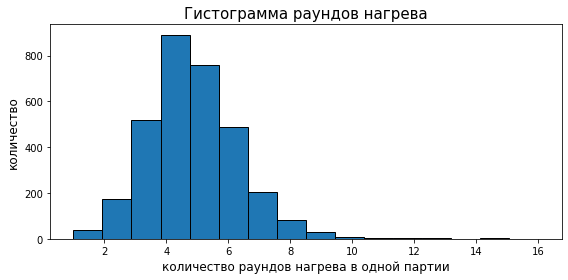

In [34]:
# Посмотрим сколько раундов нагрева приходится на одну партию
plt.figure(figsize=(8, 4))
plt.hist(data_arc_new['key'].value_counts(), edgecolor='black', bins=16)
plt.title('Гистограмма раундов нагрева', fontsize=15)
plt.ylabel('количество', fontsize=12)
plt.xlabel('количество раундов нагрева в одной партии', fontsize=12)
plt.tight_layout()
plt.show()

Обнаружено, что количество партий составляет примерно 1/4 от общего количества раундов нагрева. Необходимо отметить, что некоторые партии проходили несколько раундов нагрева.  

Например, партия 2108 была подвергнута 16 раундам нагрева, в то время как партия 530 прошла только один раунд нагрева. При этом, большинство партий проходила через 4-5 итерации нагрева. 

Создадим новый датасет, где сгруппируем данные по ключу и добавим новый признак "количество раундов нагрева", после того, как проанализируем оставшиеся признаки.

##### arc_heating_start -  время начала нагрева и arc_heating_finish - время окончания нагрева

Объеденим эти два признака в один - время нагрева дугой

In [35]:
data_arc_new['arc_heating_time'] = data_arc_new['arc_heating_finish'] - data_arc_new['arc_heating_start']
data_arc_new['arc_heating_time'] = data_arc_new['arc_heating_time'].apply(lambda x: x.total_seconds()).astype(int)
data_arc_new.head()

,key,arc_heating_start,arc_heating_finish,active_power,reactive_power,arc_heating_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148


In [36]:
#выведем общую информацию о времени нагрева дугой
data_arc_new['arc_heating_time'].describe()

count    14876.000000
mean       171.670946
std         98.186803
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: arc_heating_time, dtype: float64

Видим, что нет отрицательных и нулевых значений. Значит, что время окончания нагрева дугой всегда превышает время начала нагрева.

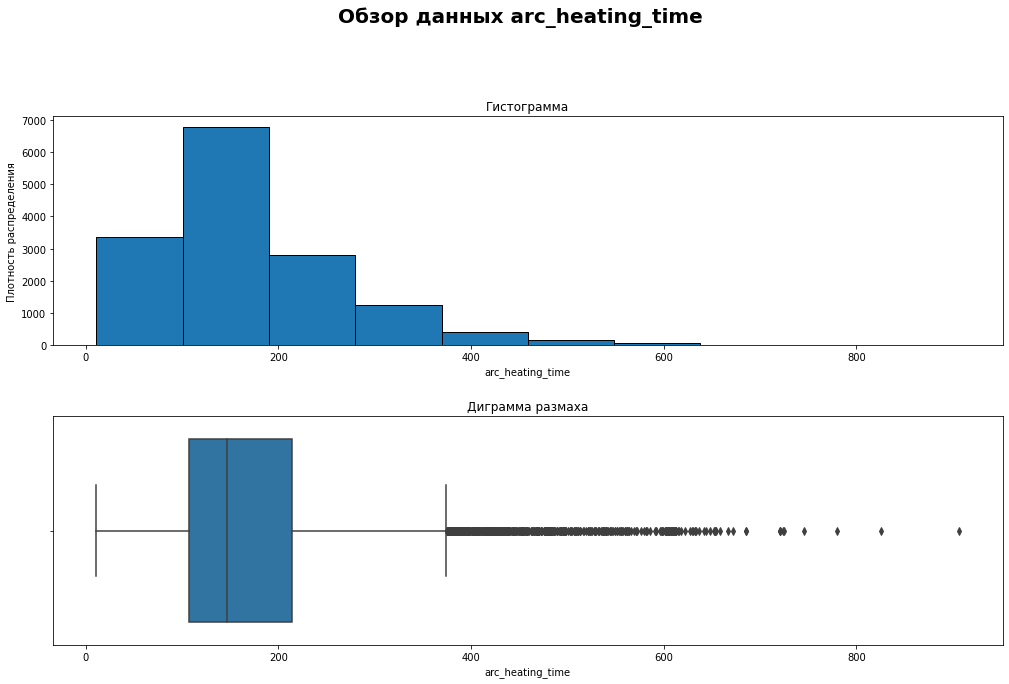

In [37]:
#Построим графики распределения времени нагрева дугой
hix_box_plot(data_arc_new,'arc_heating_time')

Данные имеют нормальное распределение с длинным правым хвостом.

Выбросы, которые мы видим на диаграмме размаха удалять не будем, так как они не являются аномальными. 

##### active_power - активная мощность

In [38]:
#выведем общую информацию значения активной мощности
data_arc_new['active_power'].describe()

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: active_power, dtype: float64

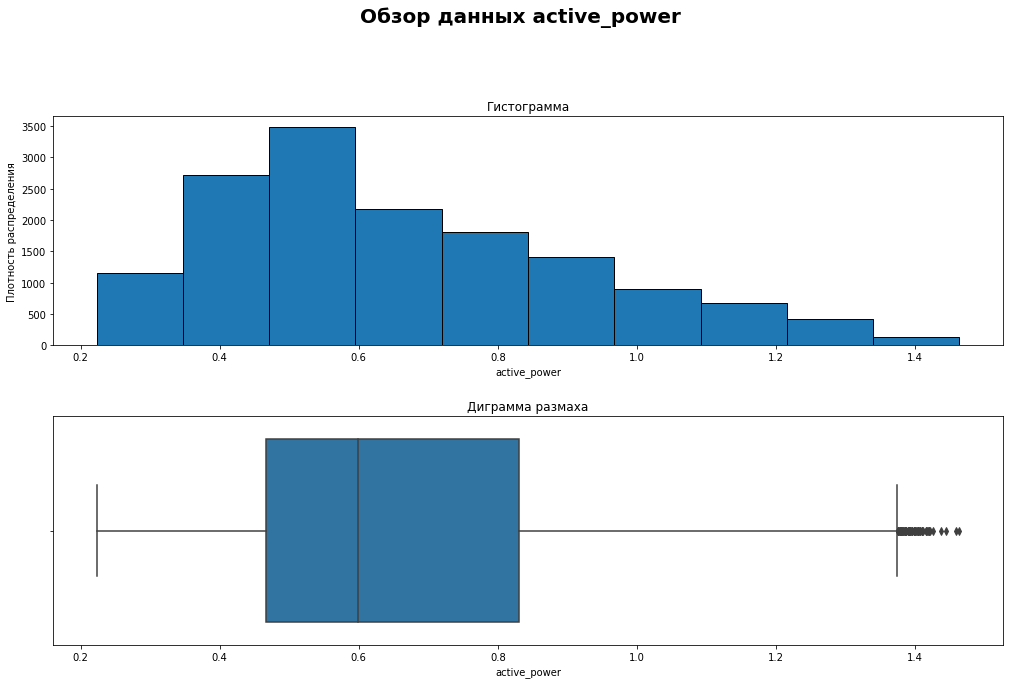

In [39]:
#Построим графики распределения  значения активной мощности
hix_box_plot(data_arc_new,'active_power')

Распределение данных похоже на нормальное с длинным правым хвостом

Выбросы, которые мы видим на диаграмме размаха удалять не будем, так как они не являются аномальными.

##### reactive_power - реактивная мощность

In [40]:
#выведем общую информацию значения реактивной мощности
data_arc_new['reactive_power'].describe()

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64

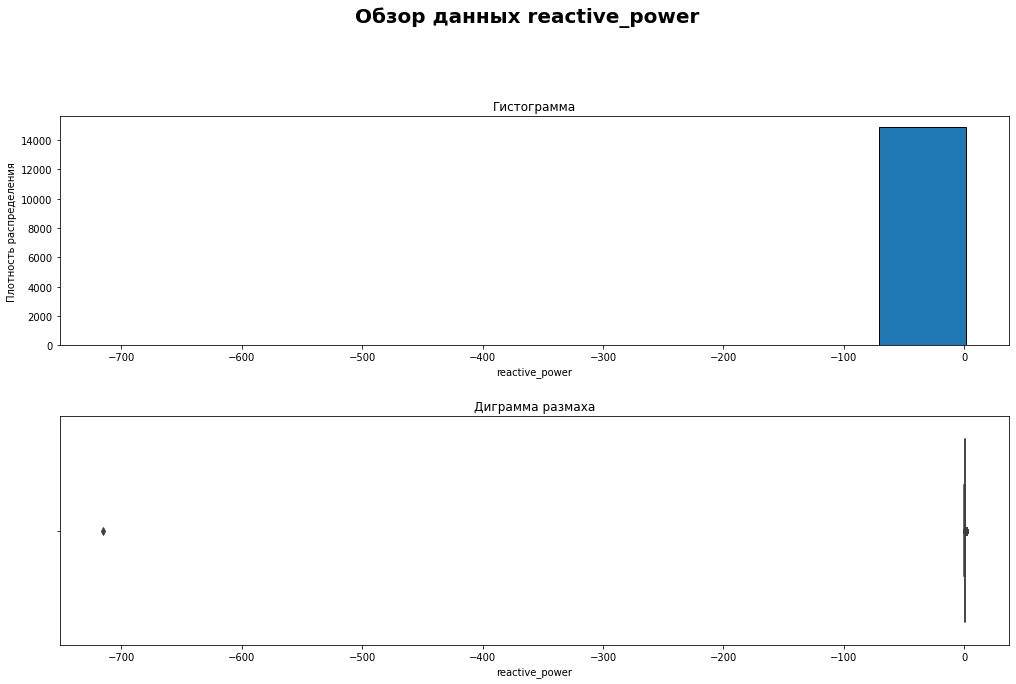

In [41]:
#Построим графики распределения  значения реактивной мощности
hix_box_plot(data_arc_new,'reactive_power')

Отрицательные значения реактивной мощности, это явно аномалия, избавимся от партий, содержащие такие значения.

In [42]:
# Выведем информацию о таких партиях
display(data_arc_new[data_arc_new['reactive_power'] <= 0])

,key,arc_heating_start,arc_heating_finish,active_power,reactive_power,arc_heating_time
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924,109


In [43]:
# Удалим партию 2116 из нашего датасета
print('Количество строк до удаления:', data_arc_new.shape[0])
data_arc_new = data_arc_new[data_arc_new['key'] != 2116]
print('Количество строк после удаления:', data_arc_new.shape[0])

Количество строк до удаления: 14876
Количество строк после удаления: 14872


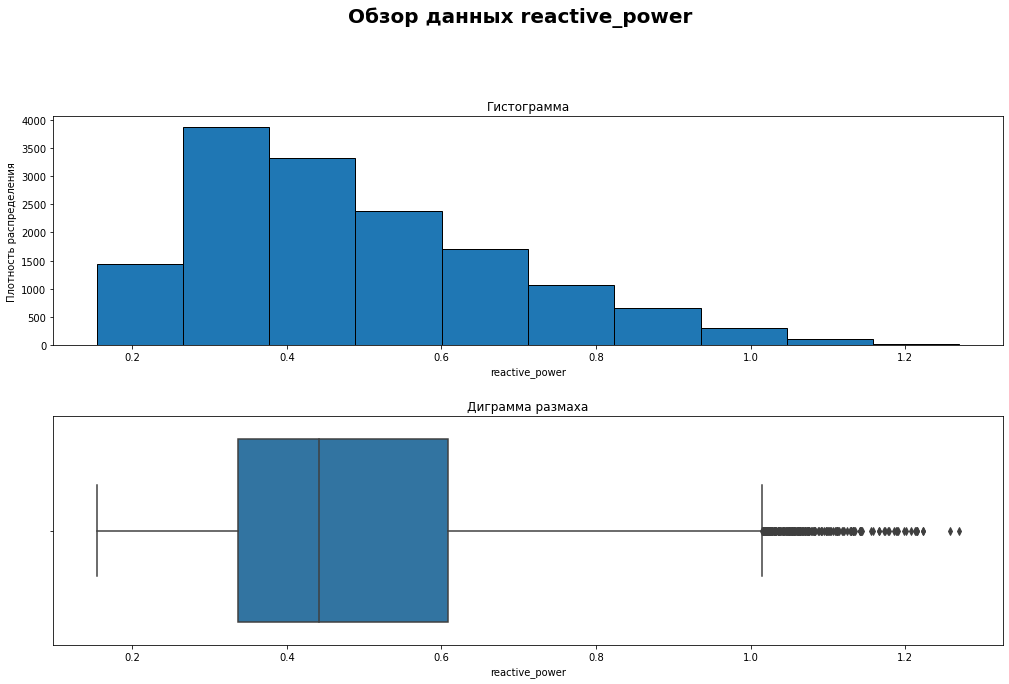

In [44]:
#Построим занаво графики распределения  значения реактивной мощности
hix_box_plot(data_arc_new,'reactive_power')

После удаления выброса, распределение данных похоже на нормальное с длинным правым хвостом.

Выбросы, которые мы видим на диаграмме размаха удалять не будем, так как они не являются аномальными.

##### full_power - полная мощность

Вычислим значение полной мощности S:

$$\displaystyle S=\sqrt{P^2+Q^2}~,$$

где P — активная мощность, Q — реактивная мощность

In [45]:
# Добавим новый признак - полная мощность
data_arc_new['full_power'] = (data_arc_new['active_power']**2 + data_arc_new['reactive_power']**2)**(0.5)
data_arc_new.head()

,key,arc_heating_start,arc_heating_finish,active_power,reactive_power,arc_heating_time,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934


In [46]:
#выведем общую информацию значения полной мощности
data_arc_new['full_power'].describe()

count    14872.000000
mean         0.823385
std          0.323494
min          0.275718
25%          0.578813
50%          0.746591
75%          1.030390
max          1.898158
Name: full_power, dtype: float64

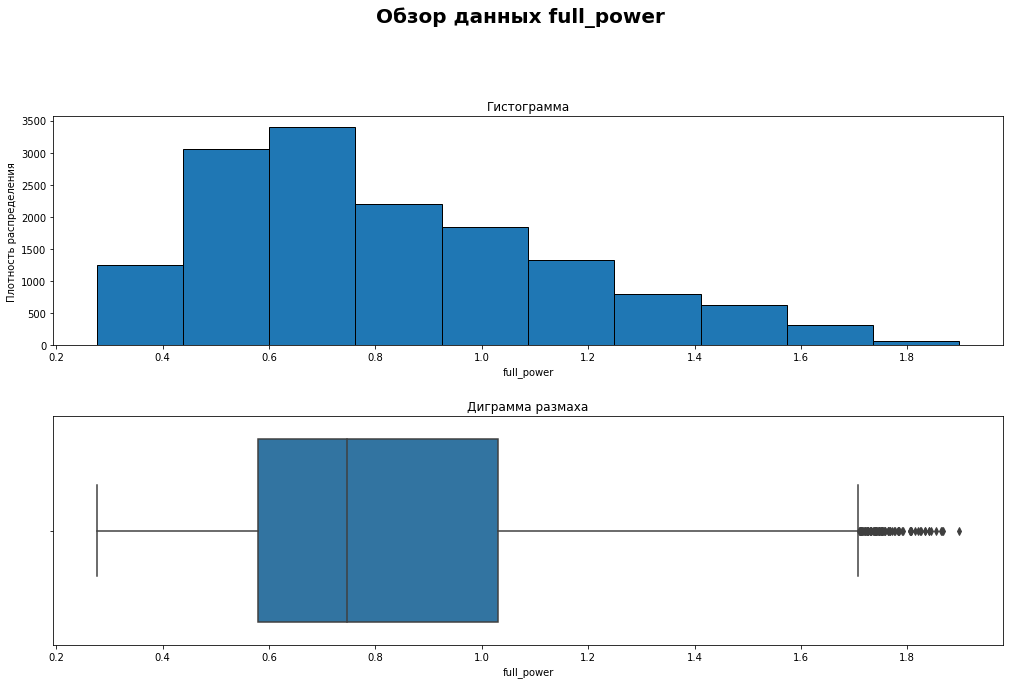

In [47]:
#Построим графики распределения  значения реактивной мощности
hix_box_plot(data_arc_new,'full_power')

Распределение данных похоже на нормальное с длинным правым хвостом.

Выбросы, которые мы видим на диаграмме размаха удалять не будем, так как они не являются аномальными

##### Итоговый датасет об электродах

Сгруппируем данные по номеру партии, добавим признаки, суммарная активная мощность, суммарная реактивная мощность, суммарная полная мощность, суммарное время нагрева и количество раундов нагрева.

In [48]:
# сгруппируем данные по номеру партии
data_arc = data_arc_new.groupby('key', as_index=False).agg(active_power_sum = ('active_power', 'sum'),
                                                            reactive_power_sum = ('reactive_power', 'sum'),
                                                            full_power_sum = ('full_power', 'sum'),
                                                            arc_heating_time_sum = ('arc_heating_time', 'sum'),
                                                            number_of_heating = ('key', 'count'))
data_arc.head()

,key,active_power_sum,reactive_power_sum,full_power_sum,arc_heating_time_sum,number_of_heating
0,1,3.036730,2.142821,3.718736,1098,5
1,2,2.139408,1.453357,2.588349,811,4
2,3,4.063641,2.937457,5.019223,655,5
3,4,2.706489,2.056992,3.400038,741,4
4,5,2.252950,1.687991,2.816980,869,4


##### Промежуточный вывод

В данных об электродах обнаружено, что количество партий составляет примерно 1/4 от общего количества раундов нагрева. Необходимо отметить, что некоторые партии проходили несколько раундов нагрева.

Например, партия 2108 была подвергнута 16 раундам нагрева, в то время как партия 530 прошла только один раунд нагрева. При этом, большинство партий проходила через 4-5 итерации нагрева.

В данных обнаружено отрицательное значения реактивной мощности, что явно является аномалией, удалили всю партию, содержащие такие значения.

Для дальнейшего анализа было принято решение создать новый датасет, объединив исходные данные по номеру партии и добавив новые признаки:
- номер партии
- суммарная активная мощность
- суммарная реактивная мощность
- суммарная полная мощность
- суммарное время нагрева
- количество раундов нагрева.

#### Данные о подаче сыпучих материалов (объём)

##### key — номер партии

Убедимся, что в данных нет повторяющихся партий

In [49]:
# Посчитаем количество уникальных значений партий
print('Количество строк в датафрейсе', data_bulk_new['key'].shape[0])
print('Количество уникальных ключей в датафрейсе', data_bulk_new['key'].unique().shape[0])

Количество строк в датафрейсе 3129
Количество уникальных ключей в датафрейсе 3129


Номер партии уникальный, группировка данных по ключу не потребуется 

##### bulk_1 … bulk_15 — объём подаваемого материала.

При первичном осмотре данных было обнаружено, что в данных есть пропуски, посчитаем их долю в каждом столбце.

In [50]:
# Процент пропусков в датасете data_bulk_new
missing_values(data_bulk_new)

,column_name,missing_count,percent_missing
0,key,0,0
1,bulk_14,323,10
2,bulk_12,679,22
3,bulk_15,881,28
4,bulk_3,1831,59
5,bulk_4,2115,68
6,bulk_6,2553,82
7,bulk_1,2877,92
8,bulk_10,2953,94
9,bulk_11,2952,94


Видим, что часть сыпучих материалов используется менее чем в 10% партиях.

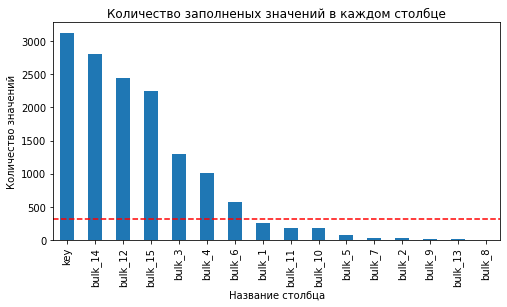

In [51]:
# Отобразим на графике количество не нулевых значений в каждом столбце
plt.figure(figsize = (8,4))
(data_bulk_new.shape[0] - data_bulk_new.isna().sum()).sort_values(ascending=False).plot(kind="bar")

# 10% от общего количества значений
plt.axhline(y=data_bulk_new.shape[0]*0.1, color='red', linestyle='--')

plt.title("Количество заполненых значений в каждом столбце")
plt.xlabel("Название столбца")
plt.ylabel("Количество значений")
plt.show()

Пропуски в датасете объясняются тем, что для текущей партии данный тип сыпучих материалов вообще не применялся. 

Заполним пропущенные значения нулями.

In [52]:
# Скопируем датафрейм и заполним пропущенные значения нулями
data_bulk = data_bulk_new.copy()
data_bulk = data_bulk.fillna(0)

data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Добавим признак суммарный объем сыпучих материалов, и удалим присыпки, которые используются менее, чем в 10% сплавов.

In [53]:
# Создадим новый столбец, который будет суммой всех bulk
data_bulk['bulk_sum'] = data_bulk.iloc[:, 1:].sum(axis=1)
data_bulk.head(5)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


In [54]:
# В итоговом датафрейме оставим, только те bulk, которые используются более чем в 10% партиях, и их суммарное количество
data_bulk = data_bulk[['key', 'bulk_14', 'bulk_12', 'bulk_15', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_sum']]
data_bulk.head(5)

,key,bulk_14,bulk_12,bulk_15,bulk_3,bulk_4,bulk_6,bulk_sum
0,1,150.0,206.0,154.0,0.0,43.0,0.0,553.0
1,2,149.0,206.0,154.0,0.0,73.0,0.0,582.0
2,3,152.0,205.0,153.0,0.0,34.0,0.0,544.0
3,4,153.0,207.0,154.0,0.0,81.0,0.0,595.0
4,5,151.0,203.0,152.0,0.0,78.0,0.0,584.0


##### Промежуточный вывод

В данных о подаче сыпучих материалов (объём) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип сыпучих материалов вообще не применялся. Заменили пропущенные значения нулями.

Добавили новый признак суммарное количество сыпучих материалов и было выявлено, что часть присыпок используется менее чем в 10% партиях. 

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- суммарное количество сыпучих материалов
- сыпучие материалы, используемые более чем в 10% партиях

#### Данные о подаче сыпучих материалов (время)

##### key — номер партии

Убедимся, что в данных нет повторяющихся партий

In [55]:
# Посчитаем количество уникальных значений партий
print('Количество строк в датафрейсе', data_bulk_time_new['key'].shape[0])
print('Количество уникальных ключей в датафрейсе', data_bulk_time_new['key'].unique().shape[0])

Количество строк в датафрейсе 3129
Количество уникальных ключей в датафрейсе 3129


Номер партии уникальный, группировка данных по ключу не потребуется

##### Bulk 1 … Bulk 15 — время подачи материала

Как можно заметить, структуры датасетов data_bulk_new и data_bulk_time_new одинаковы.

In [56]:
# Процент пропусков в датасете data_bulk_time_new
missing_values(data_bulk_time_new)

,column_name,missing_count,percent_missing
0,key,0,0
1,bulk_14,323,10
2,bulk_12,679,22
3,bulk_15,881,28
4,bulk_3,1831,59
5,bulk_4,2115,68
6,bulk_6,2553,82
7,bulk_1,2877,92
8,bulk_10,2953,94
9,bulk_11,2952,94


Создадим копию датасета, где добавим время начала и конца подачи сыпучих материалов и общее время.

In [57]:
data_bulk_time = data_bulk_time_new.copy()
data_bulk_time['bulk_time_start'] = data_bulk_time.iloc[:, 1:].min(axis=1)
data_bulk_time['bulk_time_finish'] = data_bulk_time.iloc[:, 1:].max(axis=1)
data_bulk_time['bulk_time'] = data_bulk_time['bulk_time_finish'] - data_bulk_time['bulk_time_start']
data_bulk_time['bulk_time'] = data_bulk_time['bulk_time'].apply(lambda x: x.total_seconds()).astype(int)

data_bulk_time.head(5)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_start,bulk_time_finish,bulk_time
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43,2019-05-03 11:10:43,2019-05-03 11:28:48,1085
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39,2019-05-03 11:36:50,2019-05-03 11:53:30,1000
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16,2019-05-03 12:16:16,2019-05-03 12:32:39,983
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36,2019-05-03 12:43:22,2019-05-03 12:58:00,878
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47,2019-05-03 13:30:47,2019-05-03 13:34:12,205


In [58]:
# В итоговом датафрейме оставим, только номер партии, время начала и конца подачи сыпучих материалов и общее время.
data_bulk_time = data_bulk_time[['key', 'bulk_time_start', 'bulk_time_finish', 'bulk_time']]
data_bulk_time.head()

,key,bulk_time_start,bulk_time_finish,bulk_time
0,1,2019-05-03 11:10:43,2019-05-03 11:28:48,1085
1,2,2019-05-03 11:36:50,2019-05-03 11:53:30,1000
2,3,2019-05-03 12:16:16,2019-05-03 12:32:39,983
3,4,2019-05-03 12:43:22,2019-05-03 12:58:00,878
4,5,2019-05-03 13:30:47,2019-05-03 13:34:12,205


In [59]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               3129 non-null   int64         
 1   bulk_time_start   3129 non-null   datetime64[ns]
 2   bulk_time_finish  3129 non-null   datetime64[ns]
 3   bulk_time         3129 non-null   int64         
dtypes: datetime64[ns](2), int64(2)
memory usage: 97.9 KB


Пропусков в новом датафрейте нет

In [60]:
#выведем общую информацию о времени подачи сыпучих материалов
data_bulk_time['bulk_time'].describe()

count     3129.000000
mean       964.906679
std        798.088025
min          0.000000
25%        485.000000
50%        877.000000
75%       1311.000000
max      13683.000000
Name: bulk_time, dtype: float64

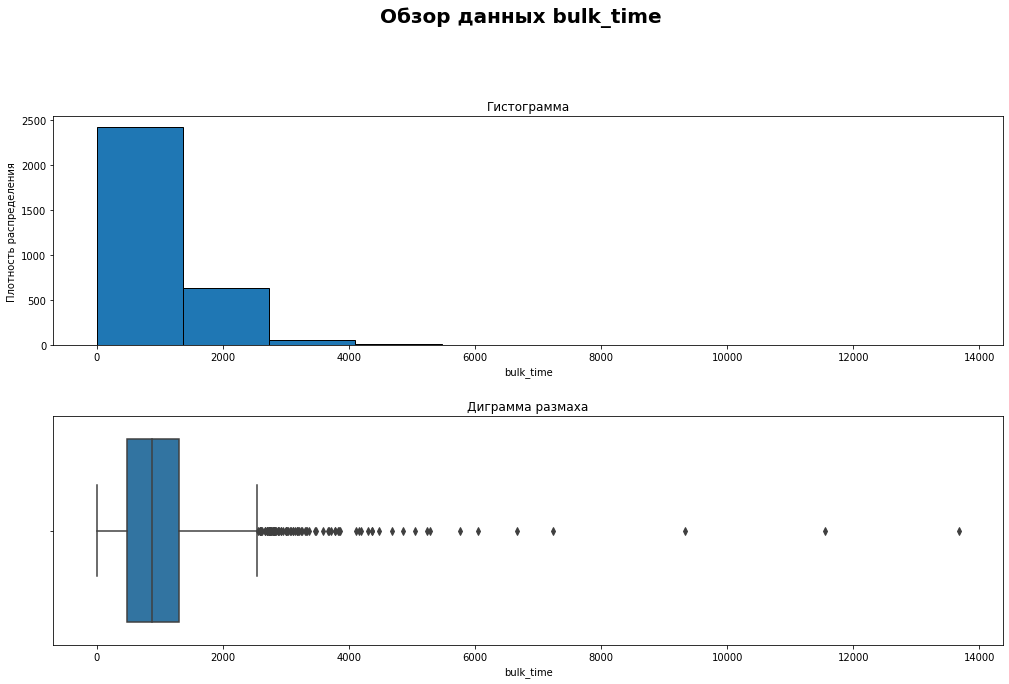

In [61]:
#Построим графики распределения времени подачи сыпучих материалов
hix_box_plot(data_bulk_time,'bulk_time')

На графике видим распределение с длинным хвостом справа, на данном этапе ничего удалять не будем, так как еще часть данных отсеется при объеденение датафреймов.

##### Промежуточный вывод

В данных о подаче сыпучих материалов (время) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип сыпучих материалов вообще не применялся. 

Структуры датасетов data_bulk_new и data_bulk_time_new одинаковы.

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- время начала подачи сыпучих материалов
- время конца подачи сыпучих материалов
- общее время.

#### Данные о продувке сплава газом

##### key — номер партии

Убедимся, что в данных нет повторяющихся партий

In [62]:
# Посчитаем количество уникальных значений партий
print('Количество строк в датафрейсе', data_gas_new['key'].shape[0])
print('Количество уникальных ключей в датафрейсе', data_gas_new['key'].unique().shape[0])

Количество строк в датафрейсе 3239
Количество уникальных ключей в датафрейсе 3239


Номер партии уникальный, группировка данных по ключу не потребуется

##### gas_1 - Объём подаваемого газа

In [63]:
#выведем общую информацию по объемам подаваемого газа
data_gas_new['gas_1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas_1, dtype: float64

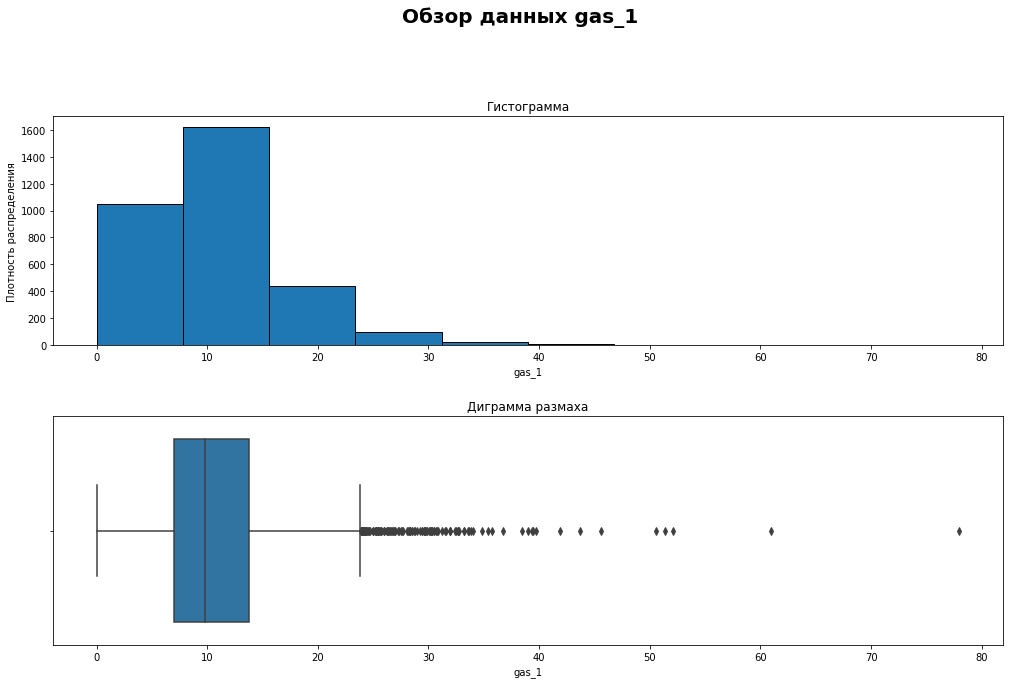

In [64]:
#Построим графики распределения объемов подаваемого газа
hix_box_plot(data_gas_new,'gas_1')

В данных представлен общий объем подаваемого газа. К сожалению, информация о том, какой объем газа использовался на каждой итерации нагрева, отсутствует.

Статистические выбросы, которые мы видим на диаграмме размаха, удалять не будем, так как модель во всех случаях, кроме аномальных, должна работать с реальными данными.

Оставим данный датафрейм без изменений.

In [65]:
# сделаем копию датафрейма для дальнейшей работы с ним
data_gas = data_gas_new.copy()

##### Промежуточный вывод

В данных о о продувке сплава газом представлен общий объем подаваемого газа. К сожалению, информация о том, какой объем газа использовался на каждой итерации нагрева, отсутствует.

Статистические выбросы, которые мы обнаружили на диаграмме размаха, удалять не стали, так как модель во всех случаях, кроме аномальных, должна работать с реальными данными.

Сделали копию датафрейма для дальнейшей работы с ним.

#### Результаты измерения температуры

##### key — номер партии

In [66]:
# Посчитаем количество уникальных значений партий
print('Количество строк в датафрейсе', data_temp_new['key'].shape[0])
print('Количество уникальных ключей в датафрейсе', data_temp_new['key'].unique().shape[0])
data_temp_new['key'].value_counts()

Количество строк в датафрейсе 18092
Количество уникальных ключей в датафрейсе 3216


2108    17
1513    16
1689    16
2567    15
322     14
        ..
556      2
1169     2
732      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

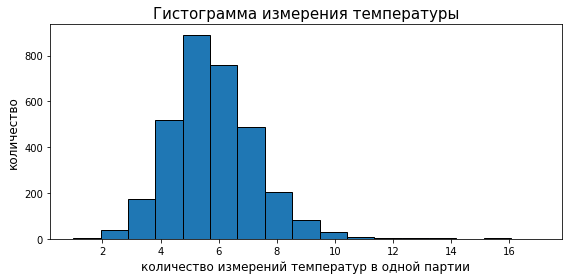

In [67]:
# Посмотрим сколько измеряли температуру за одну партию
plt.figure(figsize=(8, 4))
plt.hist(data_temp_new['key'].value_counts(), edgecolor='black', bins=17)
plt.title('Гистограмма измерения температуры', fontsize=15)
plt.ylabel('количество', fontsize=12)
plt.xlabel('количество измерений температур в одной партии', fontsize=12)
plt.tight_layout()
plt.show()

Обнаружено, что количество партий составляет примерно 1/6 от общего количества измерения температур. Необходимо отметить, что в некоторых партиях температуру измеряли по несколько раз.  

Например, в партии 2108 температуру измеряли 17 раз, в то время как в партии 279 всего один. При этом, в большинстве партий температуру измеряли 5-6 раз.

Создадим новый датасет, где сгруппируем данные по ключу и добавим новый признак "количество измерений температуры", после того, как проанализируем оставшиеся признаки.

##### temperature - значение температуры

In [68]:
# Процент пропусков в датасете data_temp_new
missing_values(data_temp_new)

,column_name,missing_count,percent_missing
0,key,0,0
1,time_measure,0,0
2,temperature,3427,19


Видим, что пропуски обнаружены только в столбце с температурой.

In [69]:
#выведем общую информацию значения температуры
data_temp_new['temperature'].describe()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temperature, dtype: float64

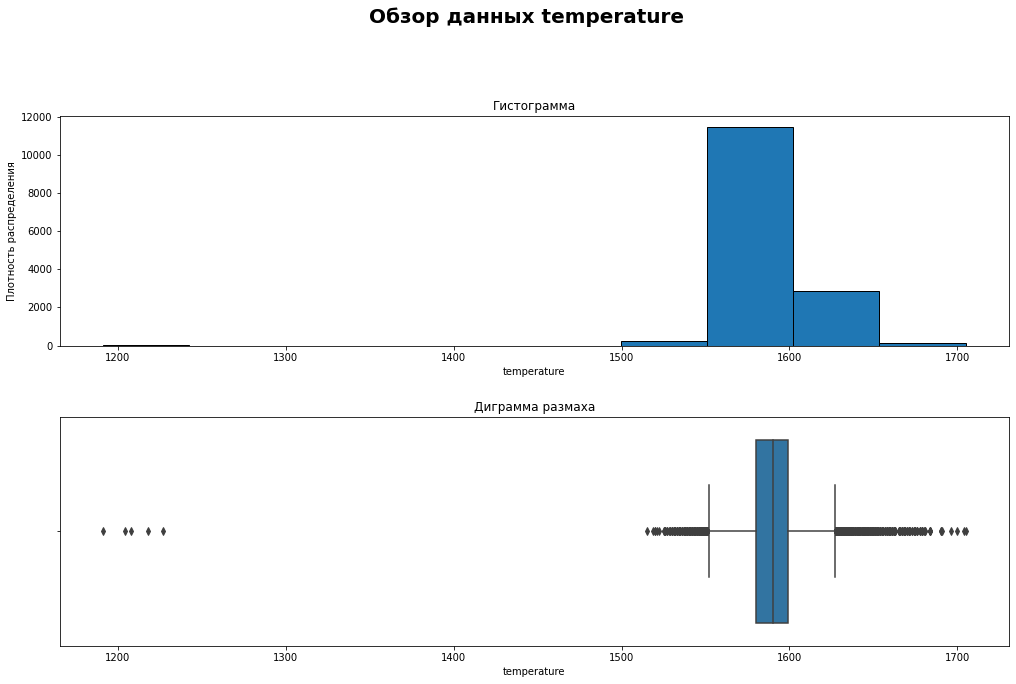

In [70]:
#Построим графики распределения значения температуры
hix_box_plot(data_temp_new,'temperature')

На диаграмме размаха видим явно аномальные значения, где температура ниже 1300 градусов. Изучим этом момент подробнее.

**Температура плавления стали**

Различные виды и марки стали плавятся при разных температурах:

- Углеродистые типы стали имеют температуру плавления от +1 370 до +1 520 °C в зависимости от углеродистости.
- Температура плавления нержавеющей стали выше, она колеблется в диапазоне от +1 375 до +1 530 °C.
- Температура плавления серебряной стали составляет около +1 500 °C.
- Коррозионностойкие марки стали плавятся при температуре от +1 400 до +1 530 °C (конкретные значения зависят от химического состава).

https://vt-metall.ru/articles/temperatura-plavleniya-stali/

In [71]:
# Запомним количество уникальных партий до начала работы с датафреймом
data_temp_new_shape = data_temp_new['key'].unique().shape[0]
data_temp_new_shape

3216

Оставим только те партии, где температура не опускалась ниже 1370 градусов. 

In [72]:
# выведем строки со значением температуры ниже 1370
data_temp_new[data_temp_new['temperature'] < 1370]

,key,time_measure,temperature
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [73]:
# Подготовим список партий на удаление
list_deleted = data_temp_new[data_temp_new['temperature'] < 1370]['key'].unique()
list_deleted

array([ 867, 1214, 1619, 2052, 2561])

In [74]:
print('Количество строк до удаления:', data_temp_new.shape[0])
print('Количество строк на удаление:', data_temp_new['key'].isin(list_deleted).sum())

data_temp_new = data_temp_new[~data_temp_new['key'].isin(list_deleted)]

print('Количество строк после удаления:', data_temp_new.shape[0])

Количество строк до удаления: 18092
Количество строк на удаление: 27
Количество строк после удаления: 18065


##### Итоговый датасет с результатами измерения температуры

Сгруппируем данные по номеру партии, добавим признаки: 

In [75]:
# отсортируем данные по номеру партии и по времени измерения
data_temp_new = data_temp_new.sort_values(by=['key', 'time_measure'], ascending=True)

Заменим на этом этапе пропуски нулями, чтобы не потерять данные при группировке.

In [76]:
# Замена пропусков нулями
data_temp_new = data_temp_new.fillna(0)

In [77]:
# Процент пропусков в датасете data_temp_new
missing_values(data_temp_new)

,column_name,missing_count,percent_missing
0,key,0,0
1,time_measure,0,0
2,temperature,0,0


In [78]:
data_temp_new.head(20)

,key,time_measure,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [79]:
# сгруппируем данные по номеру партии 
data_temp = data_temp_new.groupby('key', as_index=False).agg(time_measure_first = ('time_measure', 'first'),
                                                            time_measure_last = ('time_measure', 'last'),
                                                            temperature_first = ('temperature', 'first'),
                                                            temperature_last = ('temperature', 'last'),
                                                            number_of_temperature_measure = ('key', 'count'))
data_temp.head()

,key,time_measure_first,time_measure_last,temperature_first,temperature_last,number_of_temperature_measure
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,6
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,5
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,6
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,5
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,5


In [80]:
data_temp.tail()

,key,time_measure_first,time_measure_last,temperature_first,temperature_last,number_of_temperature_measure
3206,3237,2019-09-06 11:31:15,2019-09-06 11:55:45,1569.0,0.0,6
3207,3238,2019-09-06 12:16:15,2019-09-06 12:34:37,1584.0,0.0,4
3208,3239,2019-09-06 14:16:50,2019-09-06 15:09:55,1598.0,0.0,9
3209,3240,2019-09-06 15:25:21,2019-09-06 16:35:26,1617.0,0.0,6
3210,3241,2019-09-06 16:48:55,2019-09-06 17:30:05,1586.0,0.0,6


При группировке данных, в партиях где были пропущены начальные или конечные температуры сейчас находятся нули. 

Данные, в которых пропущена конечная температура нам не подходят, так как это целевой признак. Удалим эти партии.

In [81]:
# Удалим партии, где не указана конечная температура
data_temp = data_temp[data_temp['temperature_last'] > 0]

In [82]:
# Проверим, что нет данных, в которых не указана начальная температура
data_temp[data_temp['temperature_first'] < 0]

,key,time_measure_first,time_measure_last,temperature_first,temperature_last,number_of_temperature_measure


In [83]:
data_temp.shape[0]

2473

In [84]:
# Выедем общую информацию
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2472
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   key                            2473 non-null   int64         
 1   time_measure_first             2473 non-null   datetime64[ns]
 2   time_measure_last              2473 non-null   datetime64[ns]
 3   temperature_first              2473 non-null   float64       
 4   temperature_last               2473 non-null   float64       
 5   number_of_temperature_measure  2473 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 135.2 KB


In [85]:
# Добавим признак общее время
data_temp['temperature_time'] = data_temp['time_measure_last'] - data_temp['time_measure_first']
data_temp['temperature_time'] = data_temp['temperature_time'].apply(lambda x: x.total_seconds()).astype(int)
data_temp.head()

,key,time_measure_first,time_measure_last,temperature_first,temperature_last,number_of_temperature_measure,temperature_time
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,6,1714
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,5,1265
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,6,1753
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,5,1220
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,5,1536


In [86]:
# Выведем строки где время равно нулю
data_temp[data_temp['temperature_time'] == 0]

,key,time_measure_first,time_measure_last,temperature_first,temperature_last,number_of_temperature_measure,temperature_time
192,195,2019-05-11 00:01:36,2019-05-11 00:01:36,1583.0,1583.0,1,0
276,279,2019-05-14 10:13:01,2019-05-14 10:13:01,1603.0,1603.0,1,0


Так как нашим целевым признаком является предсказание конечной температуры, то партии где температуру измеряли всего один раз нам не подходят. Удалим их

In [87]:
print('Количество строк до удаления:', data_temp.shape[0])
print('Количество строк на удаление:', data_temp[data_temp['temperature_time'] == 0].shape[0])

data_temp = data_temp[data_temp['temperature_time'] > 0]

print('Количество строк после удаления:', data_temp.shape[0])

Количество строк до удаления: 2473
Количество строк на удаление: 2
Количество строк после удаления: 2471


Построим графики распределений для числовых признаков

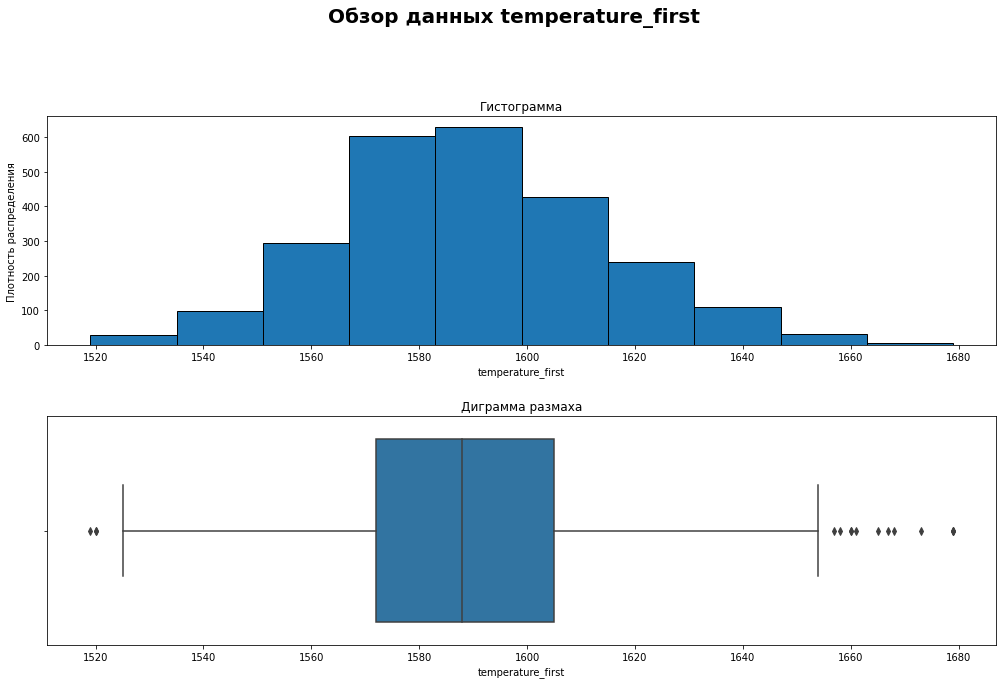

In [88]:
#Построим графики распределения значения температуры
hix_box_plot(data_temp,'temperature_first')

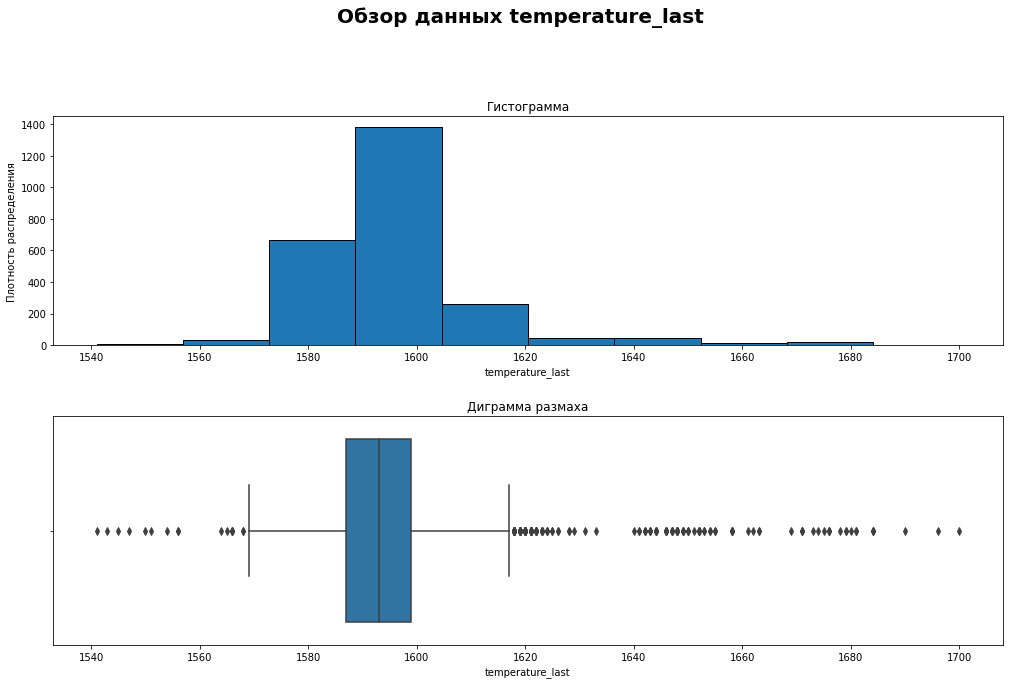

In [89]:
#Построим графики распределения значения температуры
hix_box_plot(data_temp,'temperature_last')

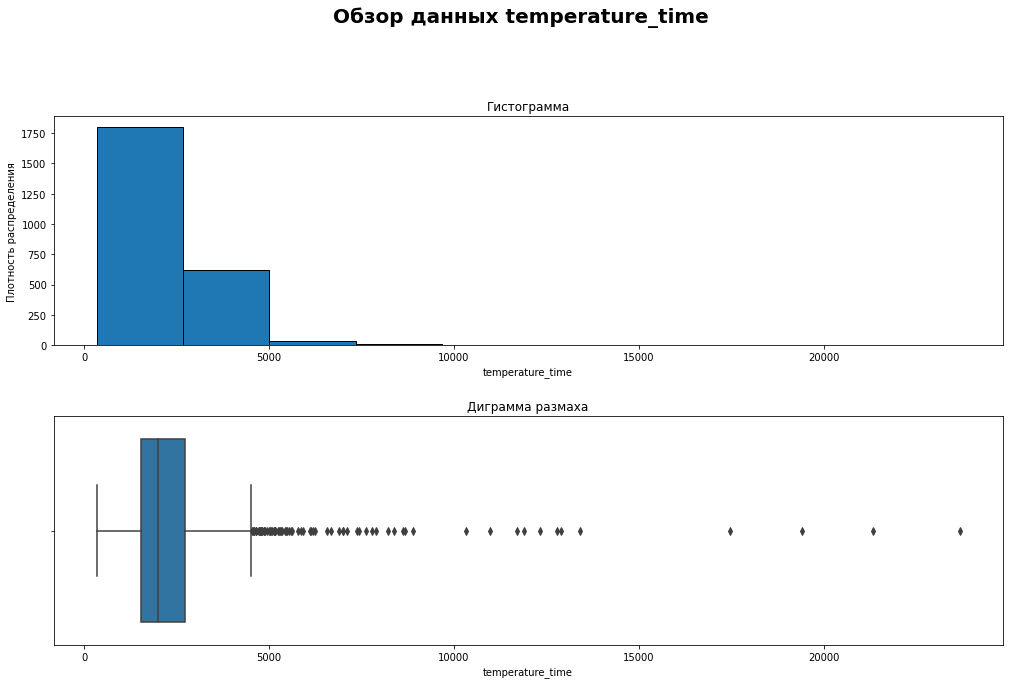

In [90]:
#Построим графики распределения времени
hix_box_plot(data_temp,'temperature_time')

Статистические выбросы, которые мы видим на диаграммах размаха, удалять не будем, так как модель во всех случаях, кроме аномальных, должна работать с реальными данными.

In [91]:
print('Количество партий до удаления:', data_temp_new_shape)
print('Количество партий после удаления:',  data_temp.shape[0])
print('Процент удаленных партий:',  round((data_temp_new_shape - data_temp.shape[0])/data_temp_new_shape*100, 2), '%')

Количество партий до удаления: 3216
Количество партий после удаления: 2471
Процент удаленных партий: 23.17 %


##### Промежуточный вывод

В данных о результатах измерения температуры обнаружено, что количество партий составляет примерно 1/6 от общего количества измерения температур. Необходимо отметить, что в некоторых партиях температуру измеряли по несколько раз.

Например, в партии 2108 температуру измеряли 17 раз, в то время как в партии 279 всего один. При этом, в большинстве партий температуру измеряли 5-6 раз.


В данных обнаружены у удалены аномальные партии, где температура плавления стали опускалась ниже 1370 градусов.

Так как нашим целевым признаком является предсказание конечной температуры, мы удалили партии где не указана конечная температура, либо данные в которых температуру измеряли всего один раз.

Для дальнейшего анализа было принято решение создать новый датасет, объединив исходные данные по номеру партии и добавив новые признаки:
- номер партии
- начальное время замера температуры
- конечное время замера температуры
- начальная температура
- конечная температура
- суммарное время
- количество измерений температуры

#### Данные о проволочных материалах (объём)

##### key — номер партии

Убедимся, что в данных нет повторяющихся партий

In [92]:
# Посчитаем количество уникальных значений партий
print('Количество строк в датафрейсе', data_wire_new['key'].shape[0])
print('Количество уникальных ключей в датафрейсе', data_wire_new['key'].unique().shape[0])

Количество строк в датафрейсе 3081
Количество уникальных ключей в датафрейсе 3081


Номер партии уникальный, группировка данных по ключу не потребуется

##### wire_1 … wire_9 — объём подаваемых проволочных материалов

При первичном осмотре данных было обнаружено, что в данных есть пропуски, посчитаем их долю в каждом столбце.

In [93]:
# Процент пропусков в датасете data_wire_new
missing_values(data_wire_new)

,column_name,missing_count,percent_missing
0,key,0,0
1,wire_1,26,1
2,wire_2,2002,65
3,wire_3,3018,98
4,wire_6,3008,98
5,wire_8,3062,99
6,wire_9,3052,99
7,wire_4,3067,100
8,wire_5,3080,100
9,wire_7,3070,100


Видим, что часть проволочных материалов используется менее чем в 10% партиях.

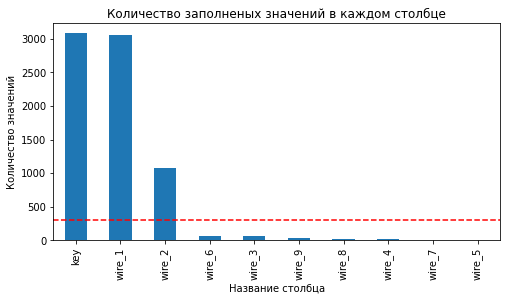

In [94]:
# Отобразим на графике количество не нулевых значений в каждом столбце
plt.figure(figsize = (8,4))
(data_wire_new.shape[0] - data_wire_new.isna().sum()).sort_values(ascending=False).plot(kind="bar")

# 10% от общего количества значений
plt.axhline(y=data_wire_new.shape[0]*0.1, color='red', linestyle='--')

plt.title("Количество заполненых значений в каждом столбце")
plt.xlabel("Название столбца")
plt.ylabel("Количество значений")
plt.show()

Пропуски в датасете объясняются тем, что для текущей партии данный тип проволочных материалов вообще не применялся. 

Заполним пропущенные значения нулями.

In [95]:
# Скопируем датафрейм и заполним пропущенные значения нулями
data_wire = data_wire_new.copy()
data_wire = data_wire.fillna(0)

data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Добавим признак суммарный объем проволочных материалов, и удалим те, которые используются менее, чем в 10% сплавов.

In [96]:
# Создадим новый столбец, который будет суммой всех wire
data_wire['wire_sum'] = data_wire.iloc[:, 1:].sum(axis=1)
data_wire.head(5)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


In [97]:
# В итоговом датафрейме оставим, только те wire, которые используются более чем в 10% партиях, и их суммарное количество
data_wire = data_wire[['key', 'wire_1', 'wire_2', 'wire_sum']]
data_wire.head(5)

,key,wire_1,wire_2,wire_sum
0,1,60.059998,0.00000,60.059998
1,2,96.052315,0.00000,96.052315
2,3,91.160157,0.00000,91.160157
3,4,89.063515,0.00000,89.063515
4,5,89.238236,9.11456,98.352796


##### Промежуточный вывод

В данных о проволочных материалах (объём) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип проволочных материалов вообще не применялся. Заменили пропущенные значения нулями.

Добавили новый признак суммарное количество проволочных материалов и было выявлено, что часть из них используется менее чем в 10% партиях. 

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- суммарное количество проволочных материалов
- проволочные материалы, используемые более чем в 10% партиях

#### Данные о проволочных материалах (время).

##### key — номер партии

Убедимся, что в данных нет повторяющихся партий

In [98]:
# Посчитаем количество уникальных значений партий
print('Количество строк в датафрейсе', data_wire_time_new['key'].shape[0])
print('Количество уникальных ключей в датафрейсе', data_wire_time_new['key'].unique().shape[0])

Количество строк в датафрейсе 3081
Количество уникальных ключей в датафрейсе 3081


Номер партии уникальный, группировка данных по ключу не потребуется

##### wire_1 … wire_9 — время подачи проволочных материалов

Как можно заметить, структуры датасетов data_wire_new и data_wire_time_new одинаковы.

In [99]:
# Процент пропусков в датасете data_bulk_time_new
missing_values(data_wire_time_new)

,column_name,missing_count,percent_missing
0,key,0,0
1,wire_1,26,1
2,wire_2,2002,65
3,wire_3,3018,98
4,wire_6,3008,98
5,wire_8,3062,99
6,wire_9,3052,99
7,wire_4,3067,100
8,wire_5,3080,100
9,wire_7,3070,100


Создадим копию датасета, где добавим время начала и конца подачи проволочных материалов и общее время.

In [100]:
data_wire_time = data_wire_time_new.copy()
data_wire_time['wire_time_start'] = data_wire_time.iloc[:, 1:].min(axis=1)
data_wire_time['wire_time_finish'] = data_wire_time.iloc[:, 1:].max(axis=1)
data_wire_time['wire_time'] = data_wire_time['wire_time_finish'] - data_wire_time['wire_time_start']
data_wire_time['wire_time'] = data_wire_time['wire_time'].apply(lambda x: x.total_seconds()).astype(int)

data_wire_time.head(5)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_start,wire_time_finish,wire_time
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:06:19,2019-05-03 11:06:19,0
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:36:50,2019-05-03 11:36:50,0
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:11:46,2019-05-03 12:11:46,0
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:43:22,2019-05-03 12:43:22,0
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:15:34,2019-05-03 13:20:44,310


In [101]:
# В итоговом датафрейме оставим, только номер партии, время начала и конца подачи проволочных материалов и общее время.
data_wire_time = data_wire_time[['key', 'wire_time_start', 'wire_time_finish', 'wire_time']]
data_wire_time.head()

,key,wire_time_start,wire_time_finish,wire_time
0,1,2019-05-03 11:06:19,2019-05-03 11:06:19,0
1,2,2019-05-03 11:36:50,2019-05-03 11:36:50,0
2,3,2019-05-03 12:11:46,2019-05-03 12:11:46,0
3,4,2019-05-03 12:43:22,2019-05-03 12:43:22,0
4,5,2019-05-03 13:15:34,2019-05-03 13:20:44,310


##### Промежуточный вывод

В данных о проволочных материалах (время) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип проволочных материалов вообще не применялся. 

Структуры датасетов data_wire_new и data_wire_time_new одинаковы.

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- время начала подачи проволочных материалов
- время конца подачи проволочных материалов
- общее время.

#### Вывод по исследовательскому анализу и предобработке данных¶

`data_arc_new`

В данных об электродах обнаружено, что количество партий составляет примерно 1/4 от общего количества раундов нагрева. Необходимо отметить, что некоторые партии проходили несколько раундов нагрева.

Например, партия 2108 была подвергнута 16 раундам нагрева, в то время как партия 530 прошла только один раунд нагрева. При этом, большинство партий проходила через 4-5 итерации нагрева.

В данных обнаружено отрицательное значения реактивной мощности, что явно является аномалией, удалили всю партию, содержащие такие значения.

Для дальнейшего анализа было принято решение создать новый датасет, объединив исходные данные по номеру партии и добавив новые признаки:
- номер партии
- суммарная активная мощность
- суммарная реактивная мощность
- суммарная полная мощность
- суммарное время нагрева
- количество раундов нагрева.

`data_bulk_new`

В данных о подаче сыпучих материалов (объём) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип сыпучих материалов вообще не применялся. Заменили пропущенные значения нулями.

Добавили новый признак суммарное количество сыпучих материалов и было выявлено, что часть присыпок используется менее чем в 10% партиях. 

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- суммарное количество сыпучих материалов
- сыпучие материалы, используемые более чем в 10% партиях

`data_bulk_time_new.csv`

В данных о подаче сыпучих материалов (время) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип сыпучих материалов вообще не применялся. 

Структуры датасетов data_bulk_new и data_bulk_time_new одинаковы.

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- время начала подачи сыпучих материалов
- время конца подачи сыпучих материалов
- общее время.

`data_gas_new`

В данных о о продувке сплава газом представлен общий объем подаваемого газа. К сожалению, информация о том, какой объем газа использовался на каждой итерации нагрева, отсутствует.

Статистические выбросы, которые мы обнаружили на диаграмме размаха, удалять не стали, так как модель во всех случаях, кроме аномальных, должна работать с реальными данными.

Сделали копию датафрейма для дальнейшей работы с ним.

`data_temp_new`

В данных о результатах измерения температуры обнаружено, что количество партий составляет примерно 1/6 от общего количества измерения температур. Необходимо отметить, что в некоторых партиях температуру измеряли по несколько раз.

Например, в партии 2108 температуру измеряли 17 раз, в то время как в партии 279 всего один. При этом, в большинстве партий температуру измеряли 5-6 раз.


В данных обнаружены у удалены аномальные партии, где температура плавления стали опускалась ниже 1370 градусов.

Так как нашим целевым признаком является предсказание конечной температуры, мы удалили партии где не указана конечная температура, либо данные в которых температуру измеряли всего один раз.

Для дальнейшего анализа было принято решение создать новый датасет, объединив исходные данные по номеру партии и добавив новые признаки:
- номер партии
- начальное время замера температуры
- конечное время замера температуры
- начальная температура
- конечная температура
- суммарное время
- количество измерений температуры

`data_wire_new`

В данных о проволочных материалах (объём) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип проволочных материалов вообще не применялся. Заменили пропущенные значения нулями.

Добавили новый признак суммарное количество проволочных материалов и было выявлено, что часть из них используется менее чем в 10% партиях. 

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- суммарное количество проволочных материалов
- проволочные материалы, используемые более чем в 10% партиях

`data_wire_time_new`

В данных о проволочных материалах (время) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип проволочных материалов вообще не применялся. 

Структуры датасетов data_wire_new и data_wire_time_new одинаковы.

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- время начала подачи проволочных материалов
- время конца подачи проволочных материалов
- общее время.

### Объединение данных

Объединим все признаки в один датафрейм.

In [102]:
# Создадим список из всех датафреймов
list_data = [data_arc, data_bulk, data_bulk_time, data_gas, data_wire, data_wire_time]

In [103]:
# Начнем объединять данные с датафрейма, где храниться наш целевой признак
data_full = data_temp

In [104]:
for data in list_data:
    data_full = data_full.merge(data, on=['key'])
    
data_full.head()

,key,time_measure_first,time_measure_last,temperature_first,temperature_last,number_of_temperature_measure,temperature_time,active_power_sum,reactive_power_sum,full_power_sum,arc_heating_time_sum,number_of_heating,bulk_14,bulk_12,bulk_15,bulk_3,bulk_4,bulk_6,bulk_sum,bulk_time_start,bulk_time_finish,bulk_time,gas_1,wire_1,wire_2,wire_sum,wire_time_start,wire_time_finish,wire_time
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,6,1714,3.036730,2.142821,3.718736,1098,5,150.0,206.0,154.0,0.0,43.0,0.0,553.0,2019-05-03 11:10:43,2019-05-03 11:28:48,1085,29.749986,60.059998,0.00000,60.059998,2019-05-03 11:06:19,2019-05-03 11:06:19,0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,5,1265,2.139408,1.453357,2.588349,811,4,149.0,206.0,154.0,0.0,73.0,0.0,582.0,2019-05-03 11:36:50,2019-05-03 11:53:30,1000,12.555561,96.052315,0.00000,96.052315,2019-05-03 11:36:50,2019-05-03 11:36:50,0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,6,1753,4.063641,2.937457,5.019223,655,5,152.0,205.0,153.0,0.0,34.0,0.0,544.0,2019-05-03 12:16:16,2019-05-03 12:32:39,983,28.554793,91.160157,0.00000,91.160157,2019-05-03 12:11:46,2019-05-03 12:11:46,0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,5,1220,2.706489,2.056992,3.400038,741,4,153.0,207.0,154.0,0.0,81.0,0.0,595.0,2019-05-03 12:43:22,2019-05-03 12:58:00,878,18.841219,89.063515,0.00000,89.063515,2019-05-03 12:43:22,2019-05-03 12:43:22,0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,5,1536,2.252950,1.687991,2.816980,869,4,151.0,203.0,152.0,0.0,78.0,0.0,584.0,2019-05-03 13:30:47,2019-05-03 13:34:12,205,5.413692,89.238236,9.11456,98.352796,2019-05-03 13:15:34,2019-05-03 13:20:44,310


#### Промежуточный вывод

Для создания основного датафрейма, к которому будут присоединяться новые признаки, был выбран датафрейм с результатами измерения температуры. Этот выбор обусловлен тем, что он содержит целевой признак, вокруг которого будет строиться анализ.

Методом объединения был выбран merge, с типом слияния left. Такой подход обеспечивает сохранение всех исходных данных и дополнительно добавляет новые признаки, не удаляя существующую информацию.

### Исследовательский анализ и предобработка данных объединённого датафрейма

#### Анализ пропусков

In [105]:
# Выведем общую информацию
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   key                            2324 non-null   int64         
 1   time_measure_first             2324 non-null   datetime64[ns]
 2   time_measure_last              2324 non-null   datetime64[ns]
 3   temperature_first              2324 non-null   float64       
 4   temperature_last               2324 non-null   float64       
 5   number_of_temperature_measure  2324 non-null   int64         
 6   temperature_time               2324 non-null   int64         
 7   active_power_sum               2324 non-null   float64       
 8   reactive_power_sum             2324 non-null   float64       
 9   full_power_sum                 2324 non-null   float64       
 10  arc_heating_time_sum           2324 non-null   int64         
 11  number_of_heating

In [106]:
# Процент пропусков в датасете data_full
missing_values(data_full)

,column_name,missing_count,percent_missing
0,key,0,0
1,wire_time_start,0,0
2,wire_sum,0,0
3,wire_2,0,0
4,wire_1,0,0
5,gas_1,0,0
6,bulk_time,0,0
7,bulk_time_finish,0,0
8,bulk_time_start,0,0
9,bulk_sum,0,0


Пропуски в столбцах bulk и wire обусловлены тем, что данный вид сыпучих или проволочных материалов не применялся при изготовлении текущей партии. После изучения датасета заменим их нулями.  

Изучим пропуски в данных об электродах и в  данных о продувке сплава газом подробнее.

In [107]:
# Выведем пропуски в данных об электродах
data_full[data_full['active_power_sum'].isnull()]

,key,time_measure_first,time_measure_last,temperature_first,temperature_last,number_of_temperature_measure,temperature_time,active_power_sum,reactive_power_sum,full_power_sum,arc_heating_time_sum,number_of_heating,bulk_14,bulk_12,bulk_15,bulk_3,bulk_4,bulk_6,bulk_sum,bulk_time_start,bulk_time_finish,bulk_time,gas_1,wire_1,wire_2,wire_sum,wire_time_start,wire_time_finish,wire_time


На этапе исследовательского анализа датафрейма с данными  об электродах в партии 2116 обнаружено отрицательное значения реактивной мощности, что явно является аномалией, поэтому данную партию было решено удалить. В объединенном датафрейме также удалим текущую партию. 

In [108]:
# Выведем пропуски в данных о продувке сплава газом
data_full[data_full['gas_1'].isnull()]

,key,time_measure_first,time_measure_last,temperature_first,temperature_last,number_of_temperature_measure,temperature_time,active_power_sum,reactive_power_sum,full_power_sum,arc_heating_time_sum,number_of_heating,bulk_14,bulk_12,bulk_15,bulk_3,bulk_4,bulk_6,bulk_sum,bulk_time_start,bulk_time_finish,bulk_time,gas_1,wire_1,wire_2,wire_sum,wire_time_start,wire_time_finish,wire_time


При анализе важно учитывать объём подаваемого газа. Заменить пропуски нулями считаю некорректно. Поскольку таких партий всего две, было принято решение их удалить.

In [109]:
list_deleted = [193, 259, 2116]
print('Количество строк до удаления:', data_full.shape[0])
print('Количество строк на удаление:', data_full['key'].isin(list_deleted).sum())

data_full = data_full[~data_full['key'].isin(list_deleted)]

print('Количество строк после удаления:', data_full.shape[0])

Количество строк до удаления: 2324
Количество строк на удаление: 0
Количество строк после удаления: 2324


In [110]:
# # Проверим есть ли партии в которые не добавляли ни сыпучие ни проволочные материалы
data_full[data_full['bulk_sum'].isnull() & data_full['wire_sum'].isnull()]

,key,time_measure_first,time_measure_last,temperature_first,temperature_last,number_of_temperature_measure,temperature_time,active_power_sum,reactive_power_sum,full_power_sum,arc_heating_time_sum,number_of_heating,bulk_14,bulk_12,bulk_15,bulk_3,bulk_4,bulk_6,bulk_sum,bulk_time_start,bulk_time_finish,bulk_time,gas_1,wire_1,wire_2,wire_sum,wire_time_start,wire_time_finish,wire_time


В описании проекта сказано, что сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат. 

В итоговом датасете есть 30 партий, в которые не добавляли ни сыпучие ни проволочные материалы. 

Необходимо уточнить у технолога, корректные ли процессы проходили в данных партиях, если нет, то удалить их. 

На данном этапе работы оставлю эти партии и заменю пропуски нулями. 

#### Проверка корректности данных

In [111]:
# Убедимся, что время конечного измерения температуры больше начального
data_full[data_full['time_measure_last'] < data_full['time_measure_first']]

,key,time_measure_first,time_measure_last,temperature_first,temperature_last,number_of_temperature_measure,temperature_time,active_power_sum,reactive_power_sum,full_power_sum,arc_heating_time_sum,number_of_heating,bulk_14,bulk_12,bulk_15,bulk_3,bulk_4,bulk_6,bulk_sum,bulk_time_start,bulk_time_finish,bulk_time,gas_1,wire_1,wire_2,wire_sum,wire_time_start,wire_time_finish,wire_time


In [112]:
# Убедимся, что время конечного добавления сыпучих материалов больше начального
data_full[data_full['bulk_time_finish'] < data_full['bulk_time_start']]

,key,time_measure_first,time_measure_last,temperature_first,temperature_last,number_of_temperature_measure,temperature_time,active_power_sum,reactive_power_sum,full_power_sum,arc_heating_time_sum,number_of_heating,bulk_14,bulk_12,bulk_15,bulk_3,bulk_4,bulk_6,bulk_sum,bulk_time_start,bulk_time_finish,bulk_time,gas_1,wire_1,wire_2,wire_sum,wire_time_start,wire_time_finish,wire_time


In [113]:
# Убедимся, что время конечного добавления проволочных материалов больше начального
data_full[data_full['wire_time_finish'] < data_full['wire_time_start']]

,key,time_measure_first,time_measure_last,temperature_first,temperature_last,number_of_temperature_measure,temperature_time,active_power_sum,reactive_power_sum,full_power_sum,arc_heating_time_sum,number_of_heating,bulk_14,bulk_12,bulk_15,bulk_3,bulk_4,bulk_6,bulk_sum,bulk_time_start,bulk_time_finish,bulk_time,gas_1,wire_1,wire_2,wire_sum,wire_time_start,wire_time_finish,wire_time


Проверим, можно ли добавить новый признак в зависимости от того, какой тип материалов начали добавлять в сталь раньше. Сыпучие или проволочные.

In [114]:
# Проверка, какой тип материалов начали добавлять в сталь раньше
data_full[data_full['bulk_time_start'] < data_full['wire_time_start']]

,key,time_measure_first,time_measure_last,temperature_first,temperature_last,number_of_temperature_measure,temperature_time,active_power_sum,reactive_power_sum,full_power_sum,arc_heating_time_sum,number_of_heating,bulk_14,bulk_12,bulk_15,bulk_3,bulk_4,bulk_6,bulk_sum,bulk_time_start,bulk_time_finish,bulk_time,gas_1,wire_1,wire_2,wire_sum,wire_time_start,wire_time_finish,wire_time


Видим, что всегда сыпучие материалы добавляют раньше проволочных, значит такой признак нам не подойдет. 

#### Обработка пропусков

In [115]:
# Заменим оставшиеся пропуски нулями
data_full = data_full.fillna(0)

In [116]:
# Процент пропусков в датасете data_full
missing_values(data_full)

,column_name,missing_count,percent_missing
0,key,0,0
1,wire_time_start,0,0
2,wire_sum,0,0
3,wire_2,0,0
4,wire_1,0,0
5,gas_1,0,0
6,bulk_time,0,0
7,bulk_time_finish,0,0
8,bulk_time_start,0,0
9,bulk_sum,0,0


#### Промежуточный вывод

На этапе  исследовательского анализа и предобработки данных объединённого датафрейма были обнаружены пропуски в данных. 

Удалили три партии, где отсутствовали данные об электродах, либо данные о продувке сплава газом. Остальные пропуски заполнили нулями. 

Так же было обнаружено 30 партий, в которые не добавляли ни сыпучие ни проволочные материалы.

Необходимо уточнить у технолога, корректные ли процессы проходили в данных партиях, если нет, то удалить их.

### Корреляционный анализ

Удалим признаки формата дата и неинформативные признаки

In [117]:
#Удалим неинформативные признаки
data_ml = data_full.drop(['key', 'time_measure_first', 'time_measure_last', 'bulk_time_start',\
                          'bulk_time_finish', 'wire_time_start', 'wire_time_finish'], axis=1)

In [118]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   temperature_first              2324 non-null   float64
 1   temperature_last               2324 non-null   float64
 2   number_of_temperature_measure  2324 non-null   int64  
 3   temperature_time               2324 non-null   int64  
 4   active_power_sum               2324 non-null   float64
 5   reactive_power_sum             2324 non-null   float64
 6   full_power_sum                 2324 non-null   float64
 7   arc_heating_time_sum           2324 non-null   int64  
 8   number_of_heating              2324 non-null   int64  
 9   bulk_14                        2324 non-null   float64
 10  bulk_12                        2324 non-null   float64
 11  bulk_15                        2324 non-null   float64
 12  bulk_3                         2324 non-null   f

В связи с тем, что не все признаки распределены нормально, для корреляционного анализа используем матрицу Phik, которая устойчива к ненормальному распределению, позволяет учитывать нелинейные зависимости и работает с различными типами признаков

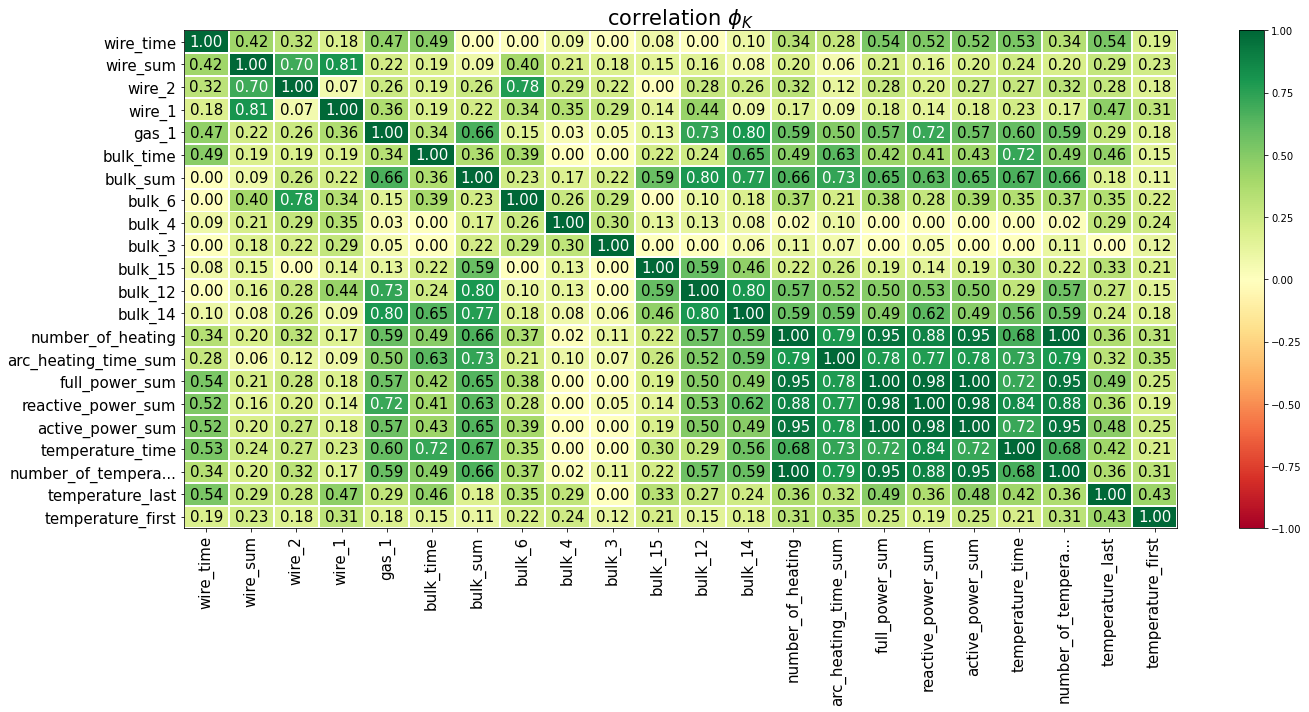

In [119]:
# вычисление коэффициентов корреляции phi для датафрейма data_ml
columns = data_ml.columns

phik_overview = data_ml.phik_matrix(interval_cols=columns)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(20, 10)
)

Из анализа матрицы корреляции датасета data_ml наблюдается мультиколлинеарность между признаками:

- active_power_sum/reactive_power_sum/full_power_sum, все эти признаки используются в формуле full_power_sum, так, что оставим только его

- number_of_heating/number_of_temperature_measure, данная связь тоже логична, количество измерений температур на единицу больше количества раундов нагрева. Оставим признак number_of_heating

In [120]:
#Удалим мультиколлинеарные признаки
data_ml = data_ml.drop(['active_power_sum', 'reactive_power_sum', 'number_of_temperature_measure'], axis=1)

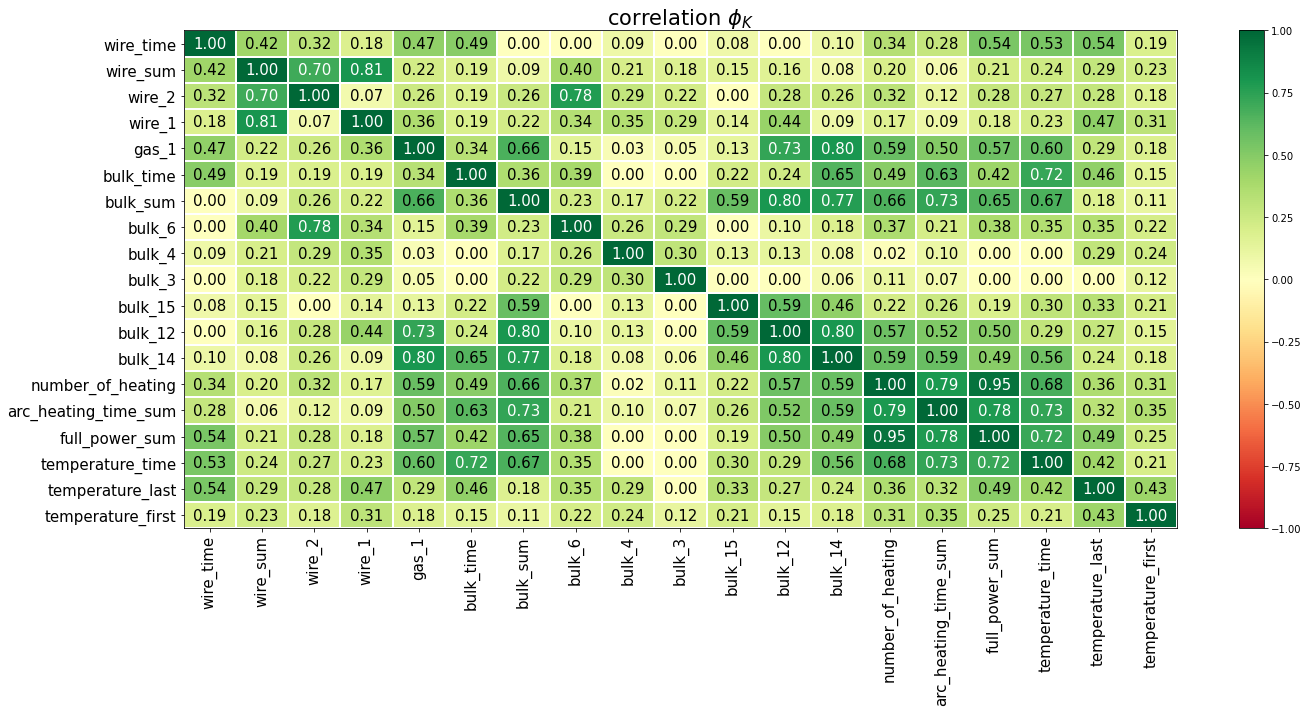

In [121]:
# Повторно построим матрицу корреляции
# вычисление коэффициентов корреляции phi для датафрейма data_ml
columns = data_ml.columns

phik_overview = data_ml.phik_matrix(interval_cols=columns)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(20, 10)
)

В датасете видим следующие закономерности:

Высокая корреляция между признаками:
- number_of_heating/full_power_sum
- temperature_time/bulk_time
- arc_heating_time_sum/bulk_sum
- bulk_sum/bulk_12
- gas_1/bulk_12
- wire_2/wire_sum

Заметная корреляция между признаками:
- temperature_time/wire_time
- full_power_sum/wire_time
- bulk_time/wire_time
- gas_1/wire_time
- wire_2/bulk_6
- gas_1/bulk_sum

Все связи логичны и объяснимы, утечки целевого признака нет.

На данном этапе больше удалять признаки не будем, возможно, вернемся к рассмотрению этого вопроса после результатов обучения моделей.

### Вывод по подготовке данных

**`Загрузка данных и первичный осмотр`**

Данные во всех датасетах соответствуют описанию.

На этапе первичного осмотра данных:
    
- привели название столбцов в единому стилю написания snake_case
- исправили тип данных в столбцах с датой на datetime
- убедились, что в данных нет явных дубликатов 
- в данных обнаружены пропуски обработаем их на исследовательском этапе работы с данными

**`Исследовательский анализ и предобработка данных`**

`data_arc_new`

В данных об электродах обнаружено, что количество партий составляет примерно 1/4 от общего количества раундов нагрева. Необходимо отметить, что некоторые партии проходили несколько раундов нагрева.

Например, партия 2108 была подвергнута 16 раундам нагрева, в то время как партия 530 прошла только один раунд нагрева. При этом, большинство партий проходила через 4-5 итерации нагрева.

В данных обнаружено отрицательное значения реактивной мощности, что явно является аномалией, удалили всю партию, содержащие такие значения.

Для дальнейшего анализа было принято решение создать новый датасет, объединив исходные данные по номеру партии и добавив новые признаки:
- номер партии
- суммарная активная мощность
- суммарная реактивная мощность
- суммарная полная мощность
- суммарное время нагрева
- количество раундов нагрева.

`data_bulk_new`

В данных о подаче сыпучих материалов (объём) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип сыпучих материалов вообще не применялся. Заменили пропущенные значения нулями.

Добавили новый признак суммарное количество сыпучих материалов и было выявлено, что часть присыпок используется менее чем в 10% партиях. 

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- суммарное количество сыпучих материалов
- сыпучие материалы, используемые более чем в 10% партиях

`data_bulk_time_new.csv`

В данных о подаче сыпучих материалов (время) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип сыпучих материалов вообще не применялся. 

Структуры датасетов data_bulk_new и data_bulk_time_new одинаковы.

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- время начала подачи сыпучих материалов
- время конца подачи сыпучих материалов
- общее время.

`data_gas_new`

В данных о о продувке сплава газом представлен общий объем подаваемого газа. К сожалению, информация о том, какой объем газа использовался на каждой итерации нагрева, отсутствует.

Статистические выбросы, которые мы обнаружили на диаграмме размаха, удалять не стали, так как модель во всех случаях, кроме аномальных, должна работать с реальными данными.

Сделали копию датафрейма для дальнейшей работы с ним.

`data_temp_new`

В данных о результатах измерения температуры обнаружено, что количество партий составляет примерно 1/6 от общего количества измерения температур. Необходимо отметить, что в некоторых партиях температуру измеряли по несколько раз.

Например, в партии 2108 температуру измеряли 17 раз, в то время как в партии 279 всего один. При этом, в большинстве партий температуру измеряли 5-6 раз.


В данных обнаружены у удалены аномальные партии, где температура плавления стали опускалась ниже 1370 градусов.

Так как нашим целевым признаком является предсказание конечной температуры, мы удалили партии где не указана конечная температура, либо данные в которых температуру измеряли всего один раз.

Для дальнейшего анализа было принято решение создать новый датасет, объединив исходные данные по номеру партии и добавив новые признаки:
- номер партии
- начальное время замера температуры
- конечное время замера температуры
- начальная температура
- конечная температура
- суммарное время
- количество измерений температуры

`data_wire_new`

В данных о проволочных материалах (объём) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип проволочных материалов вообще не применялся. Заменили пропущенные значения нулями.

Добавили новый признак суммарное количество проволочных материалов и было выявлено, что часть из них используется менее чем в 10% партиях. 

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- суммарное количество проволочных материалов
- проволочные материалы, используемые более чем в 10% партиях

`data_wire_time_new`

В данных о проволочных материалах (время) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип проволочных материалов вообще не применялся. 

Структуры датасетов data_wire_new и data_wire_time_new одинаковы.

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- время начала подачи проволочных материалов
- время конца подачи проволочных материалов
- общее время.

**`Объединение данных`**

Для создания основного датафрейма, к которому будут присоединяться новые признаки, был выбран датафрейм с результатами измерения температуры. Этот выбор обусловлен тем, что он содержит целевой признак, вокруг которого будет строиться анализ.

Методом объединения был выбран merge, с типом слияния left. Такой подход обеспечивает сохранение всех исходных данных и дополнительно добавляет новые признаки, не удаляя существующую информацию.

**`Исследовательский анализ и предобработка данных объединённого датафрейма`**

На этапе  исследовательского анализа и предобработки данных объединённого датафрейма были обнаружены пропуски в данных. 

Удалили три партии, где отсутствовали данные об электродах, либо данные о продувке сплава газом. Остальные пропуски заполнили нулями. 

Так же было обнаружено 30 партий, в которые не добавляли ни сыпучие ни проволочные материалы.

Необходимо уточнить у технолога, корректные ли процессы проходили в данных партиях, если нет, то удалить их.

**`Корреляционный анализ`**

На этапе корреляционного анализа удалили неинформативные признаки.

В связи с тем, что не все признаки распределены нормально, для корреляционного анализа используем матрицу Phik, которая устойчива к ненормальному распределению, позволяет учитывать нелинейные зависимости и работает с различными типами признаков.

Выявили мультиколлинеарность между признаками:

- active_power_sum/reactive_power_sum/full_power_sum, все эти признаки используются в формуле full_power_sum, оставили только его.

- number_of_heating/number_of_temperature_measure, данная связь тоже логична, количество измерений температур на единицу больше количества раундов нагрева. Оставим признак number_of_heating

Также в данных наблюдаем следующие закономерности:

Высокая корреляция между признаками:
- number_of_heating/full_power_sum
- temperature_time/bulk_time
- arc_heating_time_sum/bulk_sum
- bulk_sum/bulk_12
- gas_1/bulk_12
- wire_2/wire_sum

Заметная корреляция между признаками:
- temperature_time/wire_time
- full_power_sum/wire_time
- bulk_time/wire_time
- gas_1/wire_time
- wire_2/bulk_6
- gas_1/bulk_sum

Все связи логичны и объяснимы, утечки целевого признака нет.

На данном этапе больше удалять признаки не будем, возможно, вернемся к рассмотрению этого вопроса после результатов обучения моделей.

## Обучение моделей

### Подготовка данных

In [122]:
# зададим целевой признак и подготовим данные
X = data_ml.drop(['temperature_last'], axis=1)
y = data_ml['temperature_last'] 

In [123]:
# разбьём данные на обучающую и тестовую выборки в соотношении 3:1
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.25,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((1743, 18), (581, 18))

In [124]:
#Создадим список с количественными признаками
num_columns = X_train.columns.tolist()
num_columns

['temperature_first',
 'temperature_time',
 'full_power_sum',
 'arc_heating_time_sum',
 'number_of_heating',
 'bulk_14',
 'bulk_12',
 'bulk_15',
 'bulk_3',
 'bulk_4',
 'bulk_6',
 'bulk_sum',
 'bulk_time',
 'gas_1',
 'wire_1',
 'wire_2',
 'wire_sum',
 'wire_time']

Так как в итоговом датасете только количественные переменные, для масштабирования данных будем использовать StandardScaler

In [125]:
# Масштабируем количественные признаки с помощью StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

# создадим датафрейм из закодированных данных
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

X_train_scaled.shape, X_test_scaled.shape

((1743, 18), (581, 18))

Построем гистограмму частотного распределения и ящик с усами для количественных признаков, чтобы убедиться в правильности выполнения масштабирования.

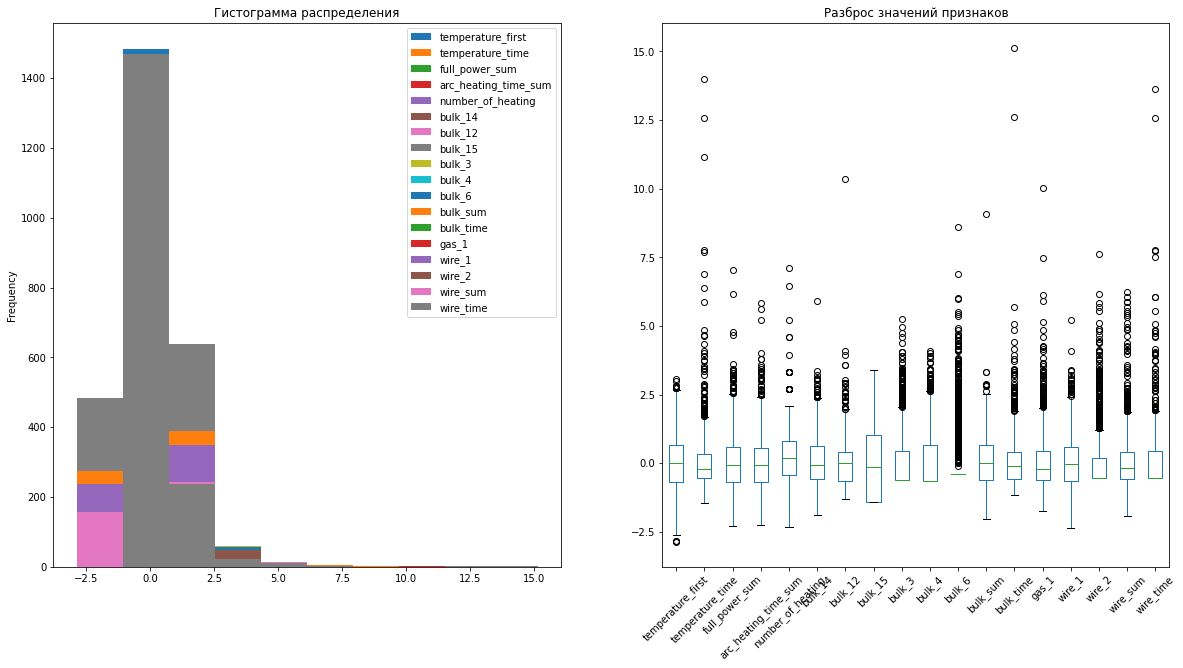

In [126]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

X_train_scaled[num_columns].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train_scaled[num_columns].plot(kind='box',   ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

#### Промежуточный вывод

На этапе подготовки данных к обучению модели разбили данные на тренировочную и тестовые выборки в соотношении 3:1. Для масштабирования данных использовали StandardScaler

### Обучение моделей

In [127]:
# #Определим функцию grid для подбора параметров
def grid(model, params):
    pipeline = Pipeline([('model', model)])    
    grid = GridSearchCV(
        pipeline, 
        cv = 5, 
        n_jobs = -1, 
        param_grid = params ,
        scoring = 'neg_mean_absolute_error', 
        verbose = False)
    grid.fit(X_train_scaled, y_train)
    print('Метрика MAE:', round(abs(grid.best_score_),2))
    print('Лучшие параметры:', grid.best_params_)
    return grid   

#### Линейная регрессия

In [128]:
#LinearRegression
lin_reg = grid(LinearRegression(), {})

Метрика MAE: 6.07
Лучшие параметры: {}


#### Decision Tree Regressor

In [129]:
#DecisionTreeRegressor
dec_tree = grid(DecisionTreeRegressor(), {'model__max_depth':range(1,10), 
                                           'model__max_features': range(1,10)})

Метрика MAE: 7.33
Лучшие параметры: {'model__max_depth': 4, 'model__max_features': 8}


#### Модель CatBoost

In [130]:
#CatBoostRegressor
cat_boost = grid(CatBoostRegressor(logging_level='Silent', random_seed=RANDOM_STATE), {'model__depth': range(1,10),
                 'model__learning_rate' : [0.01, 0.01, 0.15, 0.2],
                  'model__iterations' : [50]})

Метрика MAE: 6.12
Лучшие параметры: {'model__depth': 5, 'model__iterations': 50, 'model__learning_rate': 0.2}


####  Модель LightGBM

In [131]:
#LGBMRegressor
lgbm = grid(LGBMRegressor(random_state=RANDOM_STATE), {'model__n_estimators': [50, 100, 200],
                                                      'model__max_depth':range(1,10)})

Метрика MAE: 6.09
Лучшие параметры: {'model__max_depth': 3, 'model__n_estimators': 200}


#### RandomForestRegressor

In [132]:
#RandomForestRegressor
random_forest = grid(RandomForestRegressor(random_state=RANDOM_STATE), {'model__n_estimators': [50, 100, 200],
                                                      'model__max_depth':range(1,10)})

Метрика MAE: 6.28
Лучшие параметры: {'model__max_depth': 9, 'model__n_estimators': 100}


### Выбор лучшей модели

In [133]:
# Создадим датафрйм с результатами
results = pd.DataFrame({'model': ['Linear Regression', 'Decision Tree Regressor', 'CatBoost', \
                                   'LightGBM', 'RandomForestRegressor'],
                        'MAE': [lin_reg.best_score_, dec_tree.best_score_, cat_boost.best_score_, \
                                lgbm.best_score_, random_forest.best_score_]})
results['MAE'] = round(abs(results['MAE']), 2) 
display(results.sort_values('MAE'))

,model,MAE
0,Linear Regression,6.07
3,LightGBM,6.09
2,CatBoost,6.12
4,RandomForestRegressor,6.28
1,Decision Tree Regressor,7.33


Лучше всего на себя показала модель Линейной регрессии.

По условию задачи МАЕ не должно превышать 6,8. Значит нам подходят все модели, кроме Decision Tree Regressor.

### Тестирование моделей

In [134]:
# Проверим качество лучшей модели (LinearRegression) на тестовой выборке.
y_pred = lin_reg.predict(X_test_scaled)
mae_pred = mean_absolute_error(y_test, y_pred)
round(mae_pred, 2)

5.94

Итак, лучшая модель (LinearRegression) на тестовой выборке показала отличные результаты.

### Сравнение с константной моделью DummyRegressor

In [135]:
model_dr = DummyRegressor()
model_dr.fit(X_train_scaled, y_train)
pred_dr = model_dr.predict(X_test_scaled)
mae_dr = mean_absolute_error(y_test, pred_dr)
print(f'Метрика DummyRegressor MAE на тестовых данных: {mae_dr:.2f}\n')

Метрика DummyRegressor MAE на тестовых данных: 7.90



Модель LinearRegression значительно превзошла по эффективности константную модель. Это подтверждает, что разработка более сложных моделей и анализ данных для выявления новых закономерностей приводят к более точным прогнозам.

### Визуализация предсказаний модели

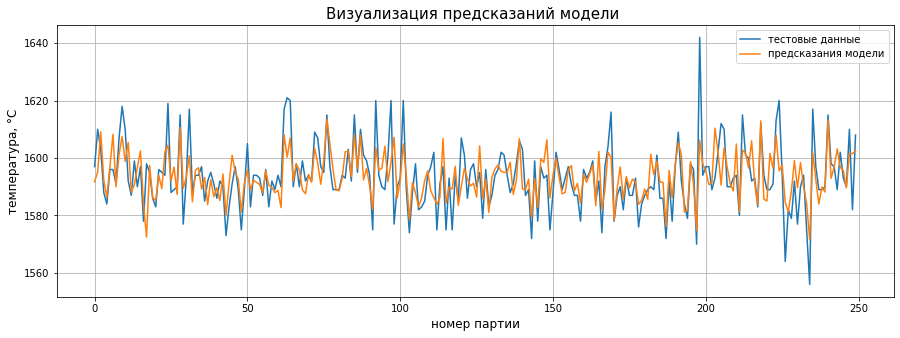

In [136]:
#Визуализация предсказаний модели
plt.figure(figsize=(15,5))
plt.plot(y_test.reset_index(drop=True)[:250], label='тестовые данные')
plt.plot(pd.Series(y_pred)[:250], label='предсказания модели')
plt.title('Визуализация предсказаний модели ', fontsize=15)
plt.xlabel('номер партии', fontsize=12)
plt.ylabel('температура, °C', fontsize=12)
plt.legend()
plt.grid(True)

###  Анализ важности признаков

In [137]:
best_model = LinearRegression()

In [138]:
best_model.fit(X_train_scaled, y_train)

LinearRegression()

In [139]:
# Оценка важности переменных методом Permutation Feature Importance
perm_importance = permutation_importance(best_model, X_test_scaled, y_test, random_state=42,
                                        n_repeats=10,scoring='neg_mean_absolute_error')
perm_importance_df = pd.DataFrame({'Feature': X_test_scaled.columns, 'Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)
perm_importance_df

,Feature,Importance
3,arc_heating_time_sum,7.680202
0,temperature_first,4.658158
11,bulk_sum,1.815314
1,temperature_time,1.659109
7,bulk_15,0.553824
14,wire_1,0.442651
4,number_of_heating,0.373496
6,bulk_12,0.149512
15,wire_2,0.126746
9,bulk_4,0.101638


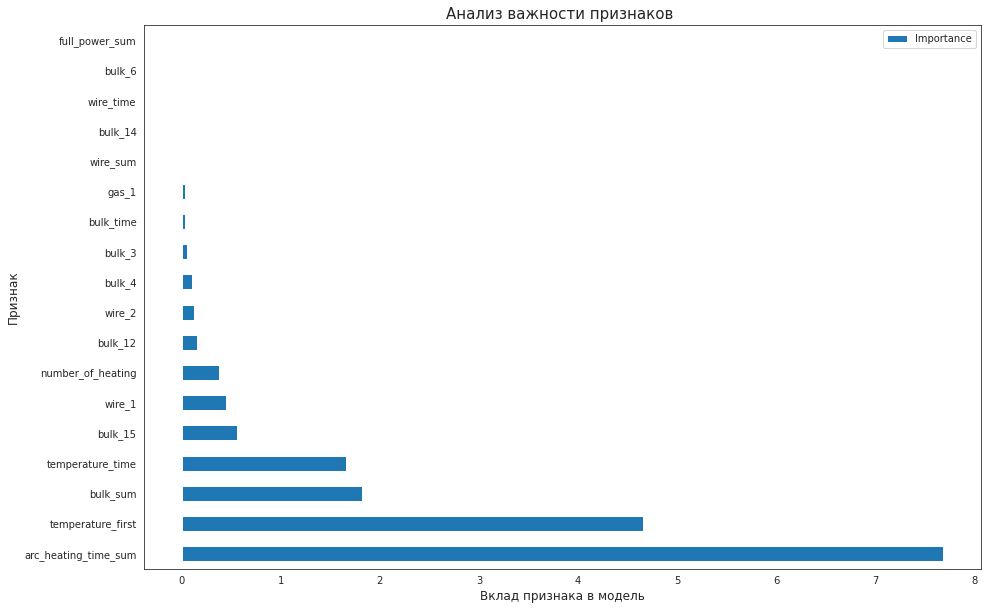

In [140]:
# представим результат графически
sns.set_style('white')
perm_importance_df.plot(x='Feature', y='Importance', kind='barh')
plt.title('Анализ важности признаков ', fontsize=15)
plt.xlabel('Вклад признака в модель', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.show()

Итак, самым важным признаком оказался arc_heating_time_sum (суммарное время нагрева дугой), на втором месте temperature_first (начальная температура), на третьем месте bulk_sum (суммарное количество поданных сыпучих материалов)

### Вывод по обучению моделей

Для поиска лучшей модели:
- была проведена подготовка данных 
- в качестве моделей рассматривались: 'Linear Regression', 'Decision Tree Regressor', 'CatBoost', 'LightGBM', 'RandomForestRegressor'
- для моделей были подобраны гиперпараметры
- для перебора параметров использовали функцию grid
- в качестве метрики оценки модели была определена метрика MAE

Лучшей моделью оказалась: 
- LinearRegression()
- Метрика лучшей модели на тренировочной выборке: 5.94
- Метрика MAE на кросс валидации: 6.07

Наиболее важным признаком оказался arc_heating_time_sum (суммарное время нагрева дугой), на втором месте temperature_first (начальная температура), на третьем месте bulk_sum (суммарное количество поданных сыпучих материалов)

## Итоговый вывод

**`Загрузка данных и первичный осмотр`**

Данные во всех датасетах соответствуют описанию.

На этапе первичного осмотра данных:
    
- привели название столбцов в единому стилю написания snake_case
- исправили тип данных в столбцах с датой на datetime
- убедились, что в данных нет явных дубликатов 
- в данных обнаружены пропуски обработаем их на исследовательском этапе работы с данными

---

**`Исследовательский анализ и предобработка данных`**

`data_arc_new`

В данных об электродах обнаружено, что количество партий составляет примерно 1/4 от общего количества раундов нагрева. Необходимо отметить, что некоторые партии проходили несколько раундов нагрева.

Например, партия 2108 была подвергнута 16 раундам нагрева, в то время как партия 530 прошла только один раунд нагрева. При этом, большинство партий проходила через 4-5 итерации нагрева.

В данных обнаружено отрицательное значения реактивной мощности, что явно является аномалией, удалили всю партию, содержащие такие значения.

Для дальнейшего анализа было принято решение создать новый датасет, объединив исходные данные по номеру партии и добавив новые признаки:
- номер партии
- суммарная активная мощность
- суммарная реактивная мощность
- суммарная полная мощность
- суммарное время нагрева
- количество раундов нагрева.

`data_bulk_new`

В данных о подаче сыпучих материалов (объём) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип сыпучих материалов вообще не применялся. Заменили пропущенные значения нулями.

Добавили новый признак суммарное количество сыпучих материалов и было выявлено, что часть присыпок используется менее чем в 10% партиях. 

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- суммарное количество сыпучих материалов
- сыпучие материалы, используемые более чем в 10% партиях

`data_bulk_time_new.csv`

В данных о подаче сыпучих материалов (время) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип сыпучих материалов вообще не применялся. 

Структуры датасетов data_bulk_new и data_bulk_time_new одинаковы.

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- время начала подачи сыпучих материалов
- время конца подачи сыпучих материалов
- общее время.

`data_gas_new`

В данных о о продувке сплава газом представлен общий объем подаваемого газа. К сожалению, информация о том, какой объем газа использовался на каждой итерации нагрева, отсутствует.

Статистические выбросы, которые мы обнаружили на диаграмме размаха, удалять не стали, так как модель во всех случаях, кроме аномальных, должна работать с реальными данными.

Сделали копию датафрейма для дальнейшей работы с ним.

`data_temp_new`

В данных о результатах измерения температуры обнаружено, что количество партий составляет примерно 1/6 от общего количества измерения температур. Необходимо отметить, что в некоторых партиях температуру измеряли по несколько раз.

Например, в партии 2108 температуру измеряли 17 раз, в то время как в партии 279 всего один. При этом, в большинстве партий температуру измеряли 5-6 раз.


В данных обнаружены у удалены аномальные партии, где температура плавления стали опускалась ниже 1370 градусов.

Так как нашим целевым признаком является предсказание конечной температуры, мы удалили партии где не указана конечная температура, либо данные в которых температуру измеряли всего один раз.

Для дальнейшего анализа было принято решение создать новый датасет, объединив исходные данные по номеру партии и добавив новые признаки:
- номер партии
- начальное время замера температуры
- конечное время замера температуры
- начальная температура
- конечная температура
- суммарное время
- количество измерений температуры

`data_wire_new`

В данных о проволочных материалах (объём) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип проволочных материалов вообще не применялся. Заменили пропущенные значения нулями.

Добавили новый признак суммарное количество проволочных материалов и было выявлено, что часть из них используется менее чем в 10% партиях. 

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- суммарное количество проволочных материалов
- проволочные материалы, используемые более чем в 10% партиях

`data_wire_time_new`

В данных о проволочных материалах (время) есть пропуски. Пропуски объясняются тем, что для текущей партии данный тип проволочных материалов вообще не применялся. 

Структуры датасетов data_wire_new и data_wire_time_new одинаковы.

Для дальнейшего анализа было принято решение создать новый датасет, в который вошли следующие признаки:
- номер партии
- время начала подачи проволочных материалов
- время конца подачи проволочных материалов
- общее время.

---

**`Объединение данных`**

Для создания основного датафрейма, к которому будут присоединяться новые признаки, был выбран датафрейм с результатами измерения температуры. Этот выбор обусловлен тем, что он содержит целевой признак, вокруг которого будет строиться анализ.

Методом объединения был выбран merge, с типом слияния left. Такой подход обеспечивает сохранение всех исходных данных и дополнительно добавляет новые признаки, не удаляя существующую информацию.

---

**`Исследовательский анализ и предобработка данных объединённого датафрейма`**

На этапе  исследовательского анализа и предобработки данных объединённого датафрейма были обнаружены пропуски в данных. 

Удалили три партии, где отсутствовали данные об электродах, либо данные о продувке сплава газом. Остальные пропуски заполнили нулями. 

Так же было обнаружено 30 партий, в которые не добавляли ни сыпучие ни проволочные материалы.

Необходимо уточнить у технолога, корректные ли процессы проходили в данных партиях, если нет, то удалить их.

---

**`Корреляционный анализ`**

На этапе корреляционного анализа удалили неинформативные признаки.

В связи с тем, что не все признаки распределены нормально, для корреляционного анализа используем матрицу Phik, которая устойчива к ненормальному распределению, позволяет учитывать нелинейные зависимости и работает с различными типами признаков.

Выявили мультиколлинеарность между признаками:

- active_power_sum/reactive_power_sum/full_power_sum, все эти признаки используются в формуле full_power_sum, оставили только его.

- number_of_heating/number_of_temperature_measure, данная связь тоже логична, количество измерений температур на единицу больше количества раундов нагрева. Оставим признак number_of_heating

Также в данных наблюдаем следующие закономерности:

Высокая корреляция между признаками:
- number_of_heating/full_power_sum
- temperature_time/bulk_time
- arc_heating_time_sum/bulk_sum
- bulk_sum/bulk_12
- gas_1/bulk_12
- wire_2/wire_sum

Заметная корреляция между признаками:
- temperature_time/wire_time
- full_power_sum/wire_time
- bulk_time/wire_time
- gas_1/wire_time
- wire_2/bulk_6
- gas_1/bulk_sum

Все связи логичны и объяснимы, утечки целевого признака нет.

На данном этапе больше удалять признаки не будем, возможно, вернемся к рассмотрению этого вопроса после результатов обучения моделей.

---

**`Обучение моделей`**

Для поиска лучшей модели:
- была проведена подготовка данных 
- в качестве моделей рассматривались: 'Linear Regression', 'Decision Tree Regressor', 'CatBoost', 'LightGBM', 'RandomForestRegressor'
- для моделей были подобраны гиперпараметры
- для перебора параметров использовали функцию grid
- в качестве метрики оценки модели была определена метрика MAE

Лучшей моделью оказалась: 
- LinearRegression()
- Метрика лучшей модели на тренировочной выборке: 5.94
- Метрика MAE на кросс валидации: 6.07

Наиболее важным признаком оказался arc_heating_time_sum (суммарное время нагрева дугой), на втором месте temperature_first (начальная температура), на третьем месте bulk_sum (суммарное количество поданных сыпучих материалов)

---

**`Рекомендации заказчику`**

Как нам известно, для оптимизации производственных расходов металлургическому комбинату «Стальная птица» нужно уменьшить потребление электроэнергии на этапе обработки стали, а для этого необходимо контролировать температуру сплава.

Модель, которая будет предсказывать температуру сплава, успешно построена и рекомендована к внедрению. 

Для улучшения предсказаний модели стоит рассмотреть использование нейронных сетей. 

А также к процессу разработки модели подключить экспертов в области металлургии, чтобы учесть факторы, которые могут не быть очевидными из данных. Кроме того, в распределении большинства данных наблюдаются длинные хвосты, и необходимо мнение эксперта о том, являются ли эти данные реалистичными или же это выбросы. Также остается вопрос по 30 партиям, в производстве которых не использовались ни сыпучие, ни проволочные материалы. 

